In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
folder_path = '/content/drive/My Drive/FYP'
os.chdir(folder_path)

# !pip install DeepXDE==0.10
!pip install deepxde
!pip install optuna

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.5 MB/s eta 0:00:00
Mon Jun  9 10:54:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+

In [2]:
import deepxde as dde
import tensorflow as tf
import numpy as np
import pandas as pd

class GlucoseModel:
    def __init__(self, pat, m_t, m_g, m_i, m_d, t_start=0, t_end=None, inverse_activated=False):
        self.pat = pat
        self.max_t = m_t
        self.glucose_scaling = m_g
        self.insulin_scaling = m_i
        self.digestion_scaling = m_d
        self.t_start = t_start
        self.t_end = t_end
        self.inverse_activated = inverse_activated
        self.epsilon_causal = 0.01

        self.filename = f"patient_{pat}_wide.csv"

        self.load_patient_data()

        # Store custom time range
        self.min_t = t_start
        self.max_t = t_end if t_end is not None else self.time_vector.max()

        if self.inverse_activated:
            self.inverse_params = self.set_inverse_parameters()
        else:
            self.set_parameters()


    def load_patient_data(self):
        df = pd.read_csv(self.filename)

        # Extract normalised input and output signals
        # self.time_vector = df["time_min"].values.astype(float)
        # self.data_t = self.time_vector[:, None]
        # self.data_g = df["glucose"].values[:, None]
        # self.data_i = df["ut"].values[:, None]
        # self.data_d = df["rt"].values[:, None]

        # Precompute tensors for lookup
        self.insulin_vector = tf.convert_to_tensor(df["ut"].fillna(0).values, dtype=tf.float32)
        self.carb_vector = tf.convert_to_tensor(df["rt"].fillna(0).values, dtype=tf.float32)


    def set_parameters(self):
        # Real patient known: only M
        self.M = 76  # kg

        # Fixed parameters based on synthetic averages
        self.kl = 1.85          # mg/dL/min GUESS
        self.ku_Vi = 0.060      # 1/min GUESS
        self.kr_Vb = 0.0022     # 1/min GUESS

        # Volumes and baseline rates
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.ksi = 235.0
        self.Ieq = (self.kl - self.kb) / 200


        self.Tu = 120.0
        self.Tr = 180.0

    def set_inverse_parameters(self, random_init=True):
        # Parameters to learn by inverse PINN
        # self.ksi = tf.math.exp(tf.Variable(tf.math.log(200.0), dtype=tf.float32, name="ksi"))
        # self.Tu = tf.math.exp(tf.Variable(tf.math.log(120.0), dtype=tf.float32, name="Tu"))
        # self.Tr = tf.math.exp(tf.Variable(tf.math.log(180.0), dtype=tf.float32, name="Tr"))
        self.M = 76  # kg

        # Fixed parameters based on synthetic averages
        self.kl = 1.85          # mg/dL/min GUESS
        self.ku_Vi = 0.060      # 1/min GUESS
        self.kr_Vb = 0.0022     # 1/min GUESS

        # Volumes and baseline rates
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M

        # self.ksi = 200.0
        self.Tu = 120.0
        self.Tr = 180.0
        if random_init:
            init_val = np.random.uniform(156.18, 315.62)  # or np.log for log-space
        else:
            init_val = 235.0  # Default midpoint
        self.log_ksi = tf.Variable(tf.math.log(init_val), dtype=tf.float32, name="log_ksi")
        ksi = tf.exp(self.log_ksi)
        self.Ieq = (self.kl - self.kb) / ksi

        return self.log_ksi


    def geometry_time(self):
        return dde.geometry.TimeDomain(self.min_t, self.max_t)


    def lookup_inputs(self, t):
        """
        Fast u(t), r(t) lookup from precomputed vectors. Input t is scalar.
        """
        idx = int(t)
        if 0 <= idx < len(self.insulin_vector):
            return self.insulin_vector[idx], self.carb_vector[idx]
        return 0.0, 0.0


    def ode(self, x, y):
        if self.inverse_activated:
            ksi = tf.exp(self.log_ksi)
        else:
            ksi = self.ksi

        t_real = tf.cast(x[:, 0:1] * tf.cast(self.max_t, tf.float32), tf.float32)
        idx = tf.cast(tf.round(t_real), tf.int32)
        idx = tf.clip_by_value(idx, 0, tf.shape(self.insulin_vector)[0] - 1)

        ut = tf.gather(self.insulin_vector, idx)
        rt = tf.gather(self.carb_vector, idx)


        # === Denormalise outputs ===
        G = y[:, 0:1] * self.glucose_scaling
        I = y[:, 1:2] * self.insulin_scaling
        D = y[:, 2:3] * self.digestion_scaling

        dG_dt = dde.grad.jacobian(y, x, i=0, j=0) * self.glucose_scaling / self.max_t
        dI_dt = dde.grad.jacobian(y, x, i=1, j=0) * self.insulin_scaling / self.max_t
        dD_dt = dde.grad.jacobian(y, x, i=2, j=0) * self.digestion_scaling / self.max_t

        d2I_dt2 = dde.grad.hessian(y, x, component=1, i=0, j=0) * self.insulin_scaling / self.max_t**2
        d2D_dt2 = dde.grad.hessian(y, x, component=2, i=0, j=0) * self.digestion_scaling / self.max_t**2

        # === Physics-informed ODEs ===
        eq_1 = (dG_dt - (-ksi * I + self.kl - self.kb + D)) / 1000
        eq_2 = (d2I_dt2 + (2 / self.Tu) * dI_dt + (1 / self.Tu ** 2) * I - ut * (self.ku_Vi / self.Tu ** 2)) / 0.01
        eq_3 = (d2D_dt2 + (2 / self.Tr) * dD_dt + (1 / self.Tr ** 2) * D - rt * (self.kr_Vb / self.Tr ** 2)) / 10

        return [eq_1, eq_2, eq_3]

        # # === Residual vector and norm ===
        # residual_vector = tf.concat([eq_1, eq_2, eq_3], axis=1)  # shape: [batch_size, 3]
        # residual_norm_sq = tf.reduce_sum(tf.square(residual_vector), axis=1, keepdims=True)  # shape: [batch_size, 1]

        # # === Cumulative sum (causal weighting logic) ===
        # residual_cumsum = tf.stop_gradient(tf.cumsum(residual_norm_sq, axis=0, exclusive=True))
        # causal_weights = tf.exp(-self.epsilon_causal * residual_cumsum)  # shape: [batch_size, 1]

        # # === Apply causal weights to raw residuals ===
        # weighted_eq_1 = causal_weights * eq_1
        # weighted_eq_2 = causal_weights * eq_2
        # weighted_eq_3 = causal_weights * eq_3

        # return [weighted_eq_1, weighted_eq_2, weighted_eq_3]


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



# **Modified MLP**

In [3]:
import tensorflow as tf
from deepxde.nn import NN


class ModifiedMLP(NN):
    def __init__(self, layers, activation="tanh", initializer="glorot_uniform"):
        super().__init__()
        self.layers = layers
        self.activation = getattr(tf.nn, activation)
        self.initializer = tf.keras.initializers.get(initializer)

        self._input_transform = None
        self._output_transform = None

        # Layers
        self.U_encoder = tf.keras.layers.Dense(
            layers[1], activation=self.activation, kernel_initializer=self.initializer
        )
        self.V_encoder = tf.keras.layers.Dense(
            layers[1], activation=self.activation, kernel_initializer=self.initializer
        )
        self.H_layers = [
            tf.keras.layers.Dense(
                layers[1], activation=self.activation, kernel_initializer=self.initializer
            )
            for _ in range(len(layers) - 3)
        ]
        self.Z_layers = [
            tf.keras.layers.Dense(
                layers[1], activation="sigmoid", kernel_initializer=self.initializer
            )
            for _ in range(len(layers) - 3)
        ]
        self.output_layer = tf.keras.layers.Dense(
            layers[-1], activation=None, kernel_initializer=self.initializer
        )

    def apply_feature_transform(self, transform):
        self._input_transform = transform

    def apply_output_transform(self, transform):
        self._output_transform = transform

    @property
    def inputs(self):
        return self.x

    @property
    def outputs(self):
        return self.y

    @property
    def targets(self):
        return self.y_

    def build(self):
        print("Building Modified MLP with tf.compat.v1 backend...")

        self.x = tf.compat.v1.placeholder(tf.float32, [None, self.layers[0]])
        self.y_ = tf.compat.v1.placeholder(tf.float32, [None, self.layers[-1]])

        inputs = self.x
        if self._input_transform is not None:
            inputs = self._input_transform(inputs)

        # Encoding path
        U = self.U_encoder(inputs)
        V = self.V_encoder(inputs)

        # Mixing path
        H = inputs
        for H_layer, Z_layer in zip(self.H_layers, self.Z_layers):
            Z = Z_layer(H)
            H = (1.0 - Z) * U + Z * V
            H = H_layer(H)

        outputs = self.output_layer(H)

        if self._output_transform is not None:
            outputs = self._output_transform(inputs, outputs)

        self.y = outputs
        self.built = True


In [3]:
import sys
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import deepxde as dde
import tensorflow as tf
from scipy import interpolate
import random

def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
    tf.compat.v1.set_random_seed(seed)
    global random_seed
    random_seed = seed

seed=1024
set_random_seed(seed)
dde.config.set_random_seed(seed)

# === SETTINGS ===
pat = "60b9c27a" # "b4bdfa85" "46f119e5" "47b5aa6b" "ab993210"
scale = "max"
loss_term = "g_only"
ini_con = "hard"
fourier = True
inverse_activated = False
noise_introduced = False
causal = False

t_start = 25000
t_end = 27880

# Network Parameters
input_size = 1
num_hidden_layers = 3
hidden_layer_size = 32
output_size = 3

num_domain = 3000
num_test = 1000
num_initial = 1
epochs = 25000
lr = 5e-5
# noise = 0.5
test_size = 0.1

# === LOAD DATA ===
os.chdir('/content/drive/My Drive/FYP/wide_format')
filename = f"patient_{pat}_wide.csv"
df = pd.read_csv(filename)

data_t = df["time_min"].values[:, None]
data_g = df["glucose"].values[:, None]
data_i = df["ut"].values[:, None]
data_d = df["rt"].values[:, None]

# Handle NaNs in glucose
valid_idx = ~np.isnan(data_g.flatten())
interp_func = interpolate.interp1d(data_t[valid_idx].flatten(), data_g[valid_idx].flatten(), kind="linear", fill_value="extrapolate")
data_g = interp_func(data_t.flatten())[:, None]

# Clip to simulation window
mask = (data_t >= t_start) & (data_t <= t_end)
data_t = data_t[mask]
data_g = data_g[mask]
data_i = data_i[mask]
data_d = data_d[mask]

# Normalize
data_t = data_t - t_start
m_t = (t_end - t_start)
data_t_normalized = data_t / m_t

if scale == 'max':
    m_g, m_i, m_d = data_g.max(), data_i.max(), data_d.max()
    data_g_normalized = data_g / m_g
    data_i_normalized = data_i / m_i
    data_d_normalized = data_d / m_d
elif scale == 'z-score':
    m_g, m_i, m_d = data_g.mean(), data_i.mean(), data_d.mean()
    sig_g, sig_i, sig_d = data_g.std(), data_i.std(), data_d.std()
    data_g_normalized = (data_g - m_g) / sig_g
    data_i_normalized = (data_i - m_i) / sig_i
    data_d_normalized = (data_d - m_d) / sig_d

# === MODEL ===
glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d, t_start, t_end, inverse_activated=inverse_activated)
if inverse_activated:
    inverse_params = glucosemodel.set_inverse_parameters()
else:
    glucosemodel.set_parameters()



geomtime = dde.geometry.TimeDomain(t_start, t_end)

# Train/test split
split_idx = int(0.9 * len(data_t_normalized))
t_in = data_t_normalized[:split_idx]
g_in = data_g_normalized[:split_idx]
i_in = data_i_normalized[:split_idx]
d_in = data_d_normalized[:split_idx]

t_fc = data_t_normalized[split_idx:]
g_fc = data_g_normalized[split_idx:]
i_fc = data_i_normalized[split_idx:]
d_fc = data_d_normalized[split_idx:]

# Reshape (important for anchors)
t_in = np.reshape(t_in, (-1, 1))
g_in = np.reshape(g_in, (-1, 1))
i_in = np.reshape(i_in, (-1, 1))
d_in = np.reshape(d_in, (-1, 1))

t_fc = np.reshape(t_fc, (-1, 1))
g_fc = np.reshape(g_fc, (-1, 1))
i_fc = np.reshape(i_fc, (-1, 1))
d_fc = np.reshape(d_fc, (-1, 1))

mask = np.ones(len(t_in), dtype=bool)
mask[::10] = False

t_train = t_in[mask]
g_train = g_in[mask]
i_train = i_in[mask]
d_train = d_in[mask]

t_test = t_in[~mask]
g_test = g_in[~mask]
i_test = i_in[~mask]
d_test = d_in[~mask]

data_t_normalized = np.reshape(data_t_normalized, (-1, 1))
data_t = np.reshape(data_t, (-1, 1))

# Initial conditions
func_init = [g_train[0], 0.1, 0.0]

def boundary(_, on_initial):
    return on_initial

ic_g = dde.IC(geomtime, lambda x: func_init[0], boundary, component=0)
ic_i = dde.IC(geomtime, lambda x: func_init[1], boundary, component=1)
ic_d = dde.IC(geomtime, lambda x: func_init[2], boundary, component=2)

observe_g = dde.PointSetBC(t_train, g_train, component=0)
observe_i = dde.PointSetBC(t_train, i_train, component=1)
observe_d = dde.PointSetBC(t_train, d_train, component=2)

if loss_term == 'g_only' and ini_con == 'hard':
    input_data = [observe_g]
elif loss_term == 'g_only' and ini_con == 'soft':
    input_data = [observe_g, ic_g, ic_i, ic_d]
elif loss_term == 'all' and ini_con == 'hard':
    input_data = [observe_g, observe_i, observe_d]
elif loss_term == 'all' and ini_con == 'soft':
    input_data = [observe_g, observe_i, observe_d, ic_g, ic_i, ic_d]

def train_model_causally(
    glucosemodel,
    t_train,
    g_train,
    i_train,
    d_train,
    loss_term="g_only",
    num_hidden_layers=5,
    hidden_layer_size=32,
    input_size=1,
    output_size=3,
    causal_window=300,
    lr=5e-5,
    epochs_per_chunk=5000,
    fourier=True,
    ini_con="hard",
    func_init=[0.5, 0.1, 0.0],  # Default ICs for G, I, D
    m_t=1.0,
    save_path=None,
):
    import deepxde as dde

    # Split into chunks
    T_total = len(t_train)
    t_chunks = [t_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    g_chunks = [g_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    i_chunks = [i_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]
    d_chunks = [d_train[i:i + causal_window] for i in range(0, T_total - causal_window, causal_window)]

    # === Shared network ===
    # net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(4)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(4)],
            axis=1
        ))

    net.apply_output_transform(lambda t, y: tf.concat([
        tf.nn.relu(g_seg[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
        tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
        tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
    ], axis=1))

    model = None

    # Initial state
    current_state = func_init  # [G0, I0, D0]

    for k in range(len(t_chunks)):
        t_seg, g_seg, i_seg, d_seg = t_chunks[k], g_chunks[k], i_chunks[k], d_chunks[k]

        t_start_k = float(t_seg[0])
        t_end_k = float(t_seg[-1])
        geom_k = dde.geometry.TimeDomain(t_start_k, t_end_k)

        def boundary(_, on_initial):
            return on_initial

        ic_g = dde.IC(geom_k, lambda x: float(g_seg[0]), boundary, component=0)
        ic_i = dde.IC(geom_k, lambda x: float(current_state[1]), boundary, component=1)
        ic_d = dde.IC(geom_k, lambda x: float(current_state[2]), boundary, component=2)

        obs_g = dde.PointSetBC(t_seg, g_seg, component=0)

        if loss_term == "g_only":
            input_data = [obs_g, ic_g, ic_i, ic_d]
        else:
            obs_i = dde.PointSetBC(t_seg, i_seg, component=1)
            obs_d = dde.PointSetBC(t_seg, d_seg, component=2)
            input_data = [obs_g, obs_i, obs_d, ic_g, ic_i, ic_d]

        ode_data_k = dde.data.PDE(geom_k, glucosemodel.ode, input_data,
                                   num_domain=len(t_seg), anchors=t_seg)

        if model is None:
            model = dde.Model(ode_data_k, net)
            model.compile("adam", lr=lr)
        else:
            model.data = ode_data_k  # Reuse model, swap data

        print(f"\n--- Training chunk {k + 1}/{len(t_chunks)} ---")
        model.train(epochs=epochs_per_chunk)

        # Predict final state from this chunk
        y_pred = model.predict(t_seg)
        current_state = y_pred[-1]  # Final predicted [G, I, D] becomes IC for next

    return net, model



# Network
ode = glucosemodel.ode
net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")
# net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])


if causal:

    net, model = train_model_causally(
        glucosemodel=glucosemodel,
        t_train=t_train,
        g_train=g_train,
        i_train=i_train,
        d_train=d_train,
        loss_term=loss_term,
        num_hidden_layers=num_hidden_layers,
        hidden_layer_size=hidden_layer_size,
        input_size=input_size,
        output_size=output_size,
        causal_window=200,  # You can adjust this
        lr=lr,
        epochs_per_chunk=10000,
        fourier=fourier,
        ini_con=ini_con,
        func_init=[g_train[0], 0.1, 0.0],  # First G, default I, D
        m_t=m_t,
        save_path="causal_trained_net"
    )

else:
    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
            tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
            tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3]),
        ], axis=1))
    # if ini_con == 'hard':
    #     net.apply_output_transform(lambda t, y: tf.concat([
    #         tf.nn.relu(y[:, 0:1] * tf.tanh(t) + func_init[0]),
    #         tf.nn.relu(y[:, 1:2] * tf.tanh(t) + func_init[1]),
    #         tf.nn.relu(y[:, 2:3] * tf.tanh(t) + func_init[2]),
    #     ], axis=1))

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    # Problem
    ode_data = dde.data.PDE(geomtime, ode, input_data,
                            num_domain=num_domain,
                            anchors=t_train,
                            num_test=num_test)

    model = dde.Model(ode_data, net)

    # Training
    if inverse_activated:
        continue_training = True
        # print("\nStage 1: Train inverse params only")
        # model.compile("adam", lr=1e-3, external_trainable_variables=inverse_params)
        # losshistory1, train_state1 = model.train(epochs=6000)

        # print("\nStage 2: Train NN only")
        # model.compile("adam", lr=5e-4)
        # losshistory2, train_state2 = model.train(epochs=4000)

        # print("\nStage 3: Joint fine-tuning")
        # model.compile("adam", lr=lr)
        # stage_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stagepat.dat")
        # losshistory3, train_state3 = model.train(epochs=50000, callbacks=[stage_logger])

        # losshistory = losshistory1
        # losshistory.loss_train += losshistory2.loss_train + losshistory3.loss_train
        # losshistory.loss_test += losshistory2.loss_test + losshistory3.loss_test
        # losshistory.steps += losshistory2.steps + losshistory3.steps
    else:
        print("\nStandard PINN training")
        model.compile("adam", lr=lr)
        # stage_logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=f"run_{pat}_params_stagepat.dat")
        losshistory, train_state = model.train(epochs=epochs)

    # loss_weights=[0.9538101420471856, 7.362619573387162, 5.1128048386948475, 2.5508328971886964]
    # loss_weights=[8.231071303389253, 1.9036850712556335, 2.722477081151682, 0.008058721484394595]
    # Final fine-tuning
    model.compile("L-BFGS-B")
    model.train()







Standard PINN training
Compiling model...
Building feed-forward neural network...
'build' took 0.115265 s

'compile' took 6.436131 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.42e-02, 2.17e-05, 2.25e-11, 1.48e-01]    [2.58e-02, 2.30e-05, 2.39e-11, 1.48e-01]    []  
1000      [4.28e-05, 6.43e-08, 1.63e-10, 2.12e-02]    [1.12e-06, 9.85e-09, 1.74e-10, 2.12e-02]    []  
2000      [2.51e-05, 4.11e-08, 1.52e-10, 2.08e-02]    [6.83e-07, 1.03e-08, 1.62e-10, 2.08e-02]    []  
3000      [1.34e-05, 2.79e-08, 1.42e-10, 2.06e-02]    [3.61e-07, 1.07e-08, 1.50e-10, 2.06e-02]    []  
4000      [3.74e-06, 1.73e-08, 1.22e-10, 2.03e-02]    [1.33e-07, 1.04e-08, 1.29e-10, 2.03e-02]    []  
5000      [3.83e-06, 1.40e-08, 9.45e-11, 2.02e-02]    [2.47e-07, 7.27e-09, 1.00e-10, 2.02e-02]    []  
6000      [3.53e-06, 1.24e-08, 7.51e-11, 2.02e-02]    [2.63e-07, 5.55e-09, 7.96e-11, 2.02e-02]    []  
7000      [1.39

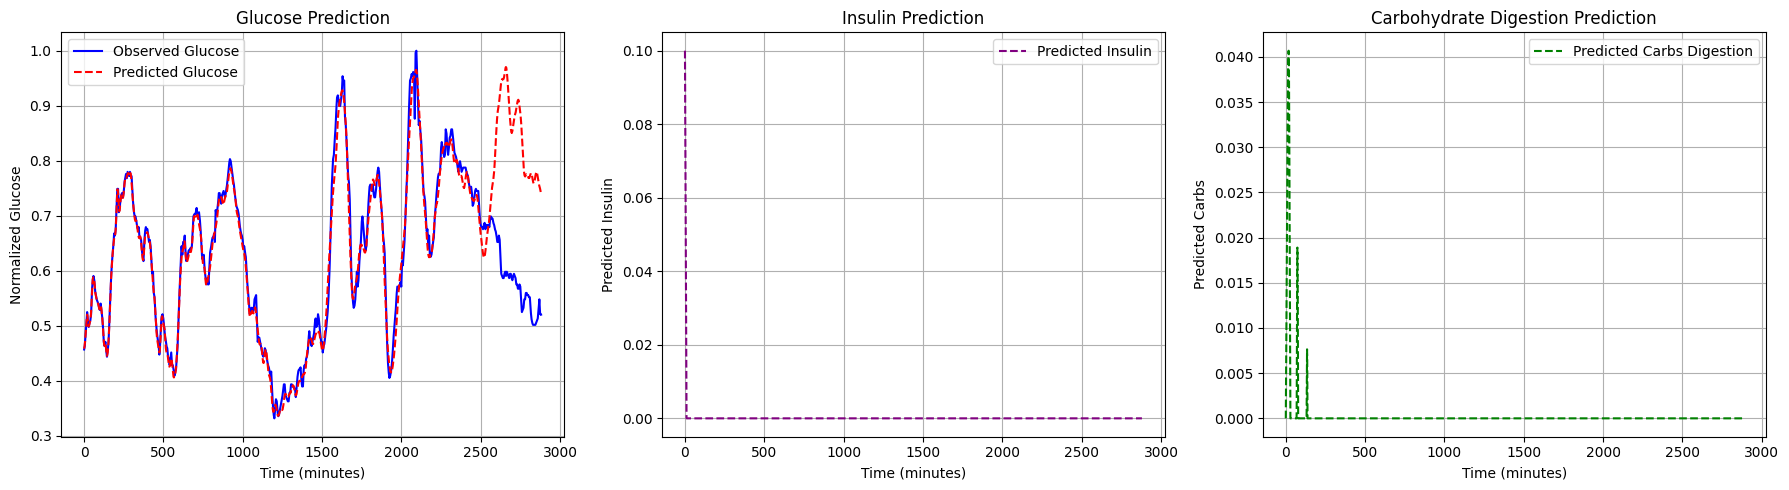

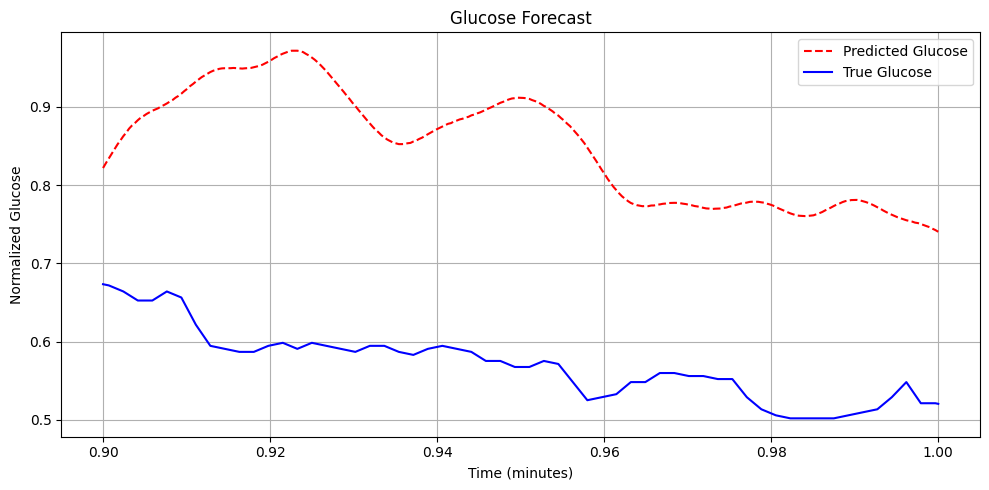

--------------------------
INTERPOLATION SEGMENT (first 90%)
G rMSE (train points): 0.020569778673269788
G rMSE (test points): 0.02118613006307225
G rMSE (full segment): 0.02063845092123501
--------------------------
FORECAST SEGMENT (last 10%)
G rMSE (forecast): 0.28411949430518607
--------------------------


In [4]:
# Predict
G_pred_data = model.predict(data_t_normalized)[:, 0:1]
G_pred_fc = model.predict(t_fc)[:, 0:1]
I_pred_data = model.predict(data_t_normalized)[:, 1:2]
D_pred_data = model.predict(data_t_normalized)[:, 2:3]

# Plot
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(data_t, data_g_normalized, label="Observed Glucose", color="blue")
plt.plot(data_t, G_pred_data, label="Predicted Glucose", linestyle="--", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Glucose")
plt.title("Glucose Prediction")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(data_t, I_pred_data, label="Predicted Insulin", color="purple", linestyle="--")
plt.xlabel("Time (minutes)")
plt.ylabel("Predicted Insulin")
plt.title("Insulin Prediction")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(data_t, D_pred_data, label="Predicted Carbs Digestion", color="green", linestyle="--")
plt.xlabel("Time (minutes)")
plt.ylabel("Predicted Carbs")
plt.title("Carbohydrate Digestion Prediction")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(t_fc, G_pred_fc, label="Predicted Glucose", linestyle="--", color="red")
plt.plot(t_fc, g_fc, label="True Glucose", color="blue")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Glucose")
plt.title("Glucose Forecast")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === INTERPOLATION SEGMENT (Train/Test Split) ===
G_pred_train = model.predict(t_train)[:, 0:1]
I_pred_train = model.predict(t_train)[:, 1:2]
D_pred_train = model.predict(t_train)[:, 2:3]

rmse_G_train_interp = np.sqrt(np.square(G_pred_train - g_train).mean())
rmse_I_train_interp = np.sqrt(np.square(I_pred_train - i_train).mean())
rmse_D_train_interp = np.sqrt(np.square(D_pred_train - d_train).mean())

G_pred_test = model.predict(t_test)[:, 0:1]
I_pred_test = model.predict(t_test)[:, 1:2]
D_pred_test = model.predict(t_test)[:, 2:3]

rmse_G_interp_test = np.sqrt(np.square(G_pred_test - g_test).mean())
rmse_I_interp_test = np.sqrt(np.square(I_pred_test - i_test).mean())
rmse_D_interp_test = np.sqrt(np.square(D_pred_test - d_test).mean())

# Full RMSE on interpolation range
t_full_interp = np.concatenate([t_train, t_test])
g_full_interp = np.concatenate([g_train, g_test])
i_full_interp = np.concatenate([i_train, i_test])
d_full_interp = np.concatenate([d_train, d_test])

G_pred_full_interp = model.predict(t_full_interp)[:, 0:1]
I_pred_full_interp = model.predict(t_full_interp)[:, 1:2]
D_pred_full_interp = model.predict(t_full_interp)[:, 2:3]

rmse_G_full_interp = np.sqrt(np.square(G_pred_full_interp - g_full_interp).mean())
rmse_I_full_interp = np.sqrt(np.square(I_pred_full_interp - i_full_interp).mean())
rmse_D_full_interp = np.sqrt(np.square(D_pred_full_interp - d_full_interp).mean())

# === FORECAST SEGMENT (last 10% of time series) ===
G_pred_forecast = model.predict(t_fc)[:, 0:1]
I_pred_forecast = model.predict(t_fc)[:, 1:2]
D_pred_forecast = model.predict(t_fc)[:, 2:3]

rmse_G_forecast = np.sqrt(np.square(G_pred_forecast - g_fc).mean())
rmse_I_forecast = np.sqrt(np.square(I_pred_forecast - i_fc).mean())
rmse_D_forecast = np.sqrt(np.square(D_pred_forecast - d_fc).mean())

# === PRINT ===
print('--------------------------')
print('INTERPOLATION SEGMENT (first 90%)')
print('G rMSE (train points):', rmse_G_train_interp)
print('G rMSE (test points):', rmse_G_interp_test)
print('G rMSE (full segment):', rmse_G_full_interp)

print('--------------------------')
print('FORECAST SEGMENT (last 10%)')
print('G rMSE (forecast):', rmse_G_forecast)
print('--------------------------')



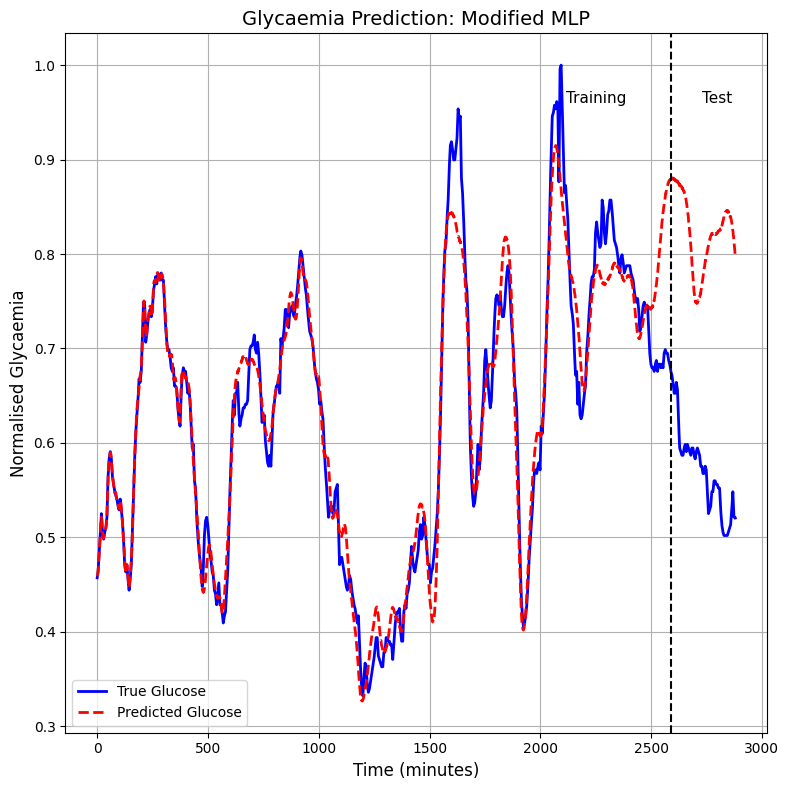

In [6]:
# === Flatten variables ===
data_t_flat = data_t.flatten()                     # Original time (not normalized)
data_g_flat = data_g_normalized.flatten()         # True glucose (normalized)
G_pred_data_flat = G_pred_data.flatten()          # Predicted glucose

# === Find split time ===
split_index = split_idx                           # Already defined from earlier
split_time = data_t_flat[split_index]             # Time (in minutes) at test start

# === Plot styled trace ===
plt.figure(figsize=(8, 8))

plt.plot(data_t_flat, data_g_flat, label="True Glucose", color="blue", linewidth=2)
plt.plot(data_t_flat, G_pred_data_flat, label="Predicted Glucose", linestyle="--", color="red", linewidth=2)

# Dashed vertical line at test split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Glycaemia", fontsize=12)
plt.title("Glycaemia Prediction: Modified MLP", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("REALglucose_prediction_modMLP.png", dpi=600, bbox_inches='tight')
plt.show()



=== RMSE ===
Glucose Train RMSE: 0.01574
Glucose Test RMSE: 0.01564
Glucose Forecast RMSE: 0.23381
----------------------------
Insulin Train RMSE: 0.02413
Insulin Test RMSE: 0.06480
Insulin Forecast RMSE: 0.02880
----------------------------
Carbs Train RMSE: 0.03071
Carbs Test RMSE: 0.03928
Carbs Forecast RMSE: 0.02635


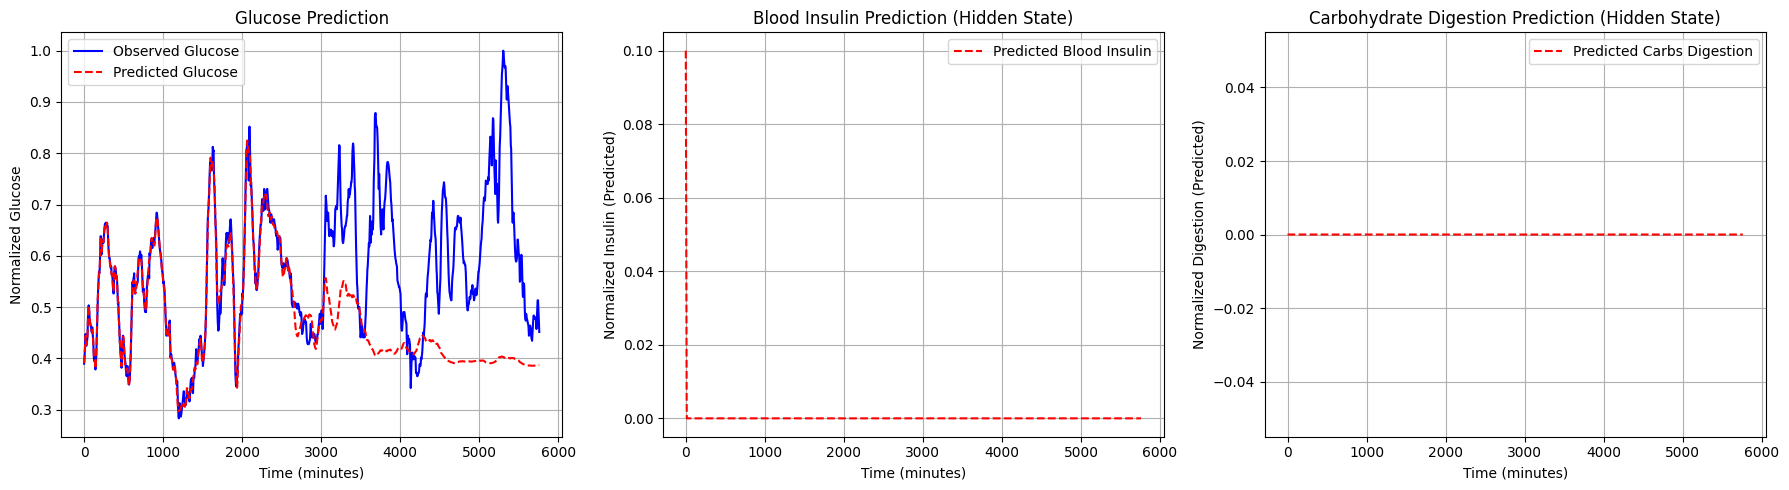

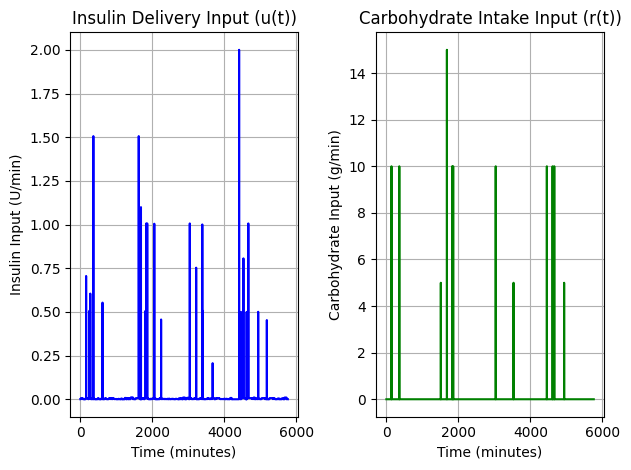

In [ ]:
# === Predictions ===
G_pred_train = model.predict(t_train)[:, 0:1]
I_pred_train = model.predict(t_train)[:, 1:2]
D_pred_train = model.predict(t_train)[:, 2:3]

G_pred_test = model.predict(t_test)[:, 0:1]
I_pred_test = model.predict(t_test)[:, 1:2]
D_pred_test = model.predict(t_test)[:, 2:3]

G_pred_fc = model.predict(t_fc)[:, 0:1]
I_pred_fc = model.predict(t_fc)[:, 1:2]
D_pred_fc = model.predict(t_fc)[:, 2:3]

# === RMSE Calculation ===
rmse_G_train = np.sqrt(np.mean((G_pred_train - g_train)**2))
rmse_G_test = np.sqrt(np.mean((G_pred_test - g_test)**2))
rmse_G_fc = np.sqrt(np.mean((G_pred_fc - g_fc)**2))

rmse_I_train = np.sqrt(np.mean((I_pred_train - i_train)**2))
rmse_I_test = np.sqrt(np.mean((I_pred_test - i_test)**2))
rmse_I_fc = np.sqrt(np.mean((I_pred_fc - i_fc)**2))

rmse_D_train = np.sqrt(np.mean((D_pred_train - d_train)**2))
rmse_D_test = np.sqrt(np.mean((D_pred_test - d_test)**2))
rmse_D_fc = np.sqrt(np.mean((D_pred_fc - d_fc)**2))


# === Display RMSE Results ===
print("\n=== RMSE ===")
print(f"Glucose Train RMSE: {rmse_G_train:.5f}")
print(f"Glucose Test RMSE: {rmse_G_test:.5f}")
print(f"Glucose Forecast RMSE: {rmse_G_fc:.5f}")
print("----------------------------")
print(f"Insulin Train RMSE: {rmse_I_train:.5f}")
print(f"Insulin Test RMSE: {rmse_I_test:.5f}")
print(f"Insulin Forecast RMSE: {rmse_I_fc:.5f}")
print("----------------------------")
print(f"Carbs Train RMSE: {rmse_D_train:.5f}")
print(f"Carbs Test RMSE: {rmse_D_test:.5f}")
print(f"Carbs Forecast RMSE: {rmse_D_fc:.5f}")
print("============================")

# === Plotting ===
G_pred_data = model.predict(data_t_normalized)[:, 0:1]
I_pred_data = model.predict(data_t_normalized)[:, 1:2]
D_pred_data = model.predict(data_t_normalized)[:, 2:3]

plt.figure(figsize=(18, 5))

# Glucose Plot
plt.subplot(1, 3, 1)
plt.plot(data_t, data_g_normalized, label="Observed Glucose", color="blue")
plt.plot(data_t, G_pred_data, label="Predicted Glucose", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Glucose")
plt.title("Glucose Prediction")
plt.legend()
plt.grid(True)

# Insulin Prediction Plot
plt.subplot(1, 3, 2)
plt.plot(data_t, I_pred_data, label="Predicted Blood Insulin", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Insulin (Predicted)")
plt.title("Blood Insulin Prediction (Hidden State)")
plt.legend()
plt.grid(True)

# Carbs Digestion Prediction Plot
plt.subplot(1, 3, 3)
plt.plot(data_t, D_pred_data, label="Predicted Carbs Digestion", linestyle="dashed", color="red")
plt.xlabel("Time (minutes)")
plt.ylabel("Normalized Digestion (Predicted)")
plt.title("Carbohydrate Digestion Prediction (Hidden State)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Insulin input (ut)
plt.subplot(1, 2, 1)
plt.plot(data_t.flatten(), data_i.flatten(), color="blue")
plt.title("Insulin Delivery Input (u(t))")
plt.xlabel("Time (minutes)")
plt.ylabel("Insulin Input (U/min)")
plt.grid(True)

# Carbohydrate input (rt)
plt.subplot(1, 2, 2)
plt.plot(data_t.flatten(), data_d.flatten(), color="green")
plt.title("Carbohydrate Intake Input (r(t))")
plt.xlabel("Time (minutes)")
plt.ylabel("Carbohydrate Input (g/min)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [6]:
import os
import numpy as np
import pandas as pd
import deepxde as dde
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval

# === Global Settings ===
patients = ("60b9c27a", "b4bdfa85", "46f119e5", "47b5aa6b", "ab993210")
num_runs = 5
epochs = 25000
learning_rate = 5e-5
inverse_activated = True
ini_con = "hard"
fourier = True

t_start = 25000
t_end = 27880

results = []

for pat in patients:
    print(f"\n=== Patient {pat} ===")
    os.chdir('/content/drive/My Drive/FYP/wide_format')
    filename = f"patient_{pat}_wide.csv"
    df = pd.read_csv(filename)

    data_t = df["time_min"].values[:, None]
    data_g = df["glucose"].values[:, None]
    data_i = df["ut"].values[:, None]
    data_d = df["rt"].values[:, None]

    # Handle NaNs in glucose
    valid_idx = ~np.isnan(data_g.flatten())
    interp_func = interpolate.interp1d(data_t[valid_idx].flatten(), data_g[valid_idx].flatten(), kind="linear", fill_value="extrapolate")
    data_g = interp_func(data_t.flatten())[:, None]

    # Clip to simulation window
    mask = (data_t >= t_start) & (data_t <= t_end)
    data_t = data_t[mask]
    data_g = data_g[mask]
    data_i = data_i[mask]
    data_d = data_d[mask]

    # Normalize
    data_t = data_t - t_start
    m_t = (t_end - t_start)
    data_t_normalized = data_t / m_t

    if scale == 'max':
        m_g, m_i, m_d = data_g.max(), data_i.max(), data_d.max()
        data_g_normalized = data_g / m_g
        data_i_normalized = data_i / m_i
        data_d_normalized = data_d / m_d
    elif scale == 'z-score':
        m_g, m_i, m_d = data_g.mean(), data_i.mean(), data_d.mean()
        sig_g, sig_i, sig_d = data_g.std(), data_i.std(), data_d.std()
        data_g_normalized = (data_g - m_g) / sig_g
        data_i_normalized = (data_i - m_i) / sig_i
        data_d_normalized = (data_d - m_d) / sig_d

    # Train/test split
    split_idx = int(0.9 * len(data_t_normalized))
    t_in = data_t_normalized[:split_idx]
    g_in = data_g_normalized[:split_idx]
    i_in = data_i_normalized[:split_idx]
    d_in = data_d_normalized[:split_idx]

    t_fc = data_t_normalized[split_idx:]
    g_fc = data_g_normalized[split_idx:]
    i_fc = data_i_normalized[split_idx:]
    d_fc = data_d_normalized[split_idx:]

    # Reshape (important for anchors)
    t_in = np.reshape(t_in, (-1, 1))
    g_in = np.reshape(g_in, (-1, 1))
    i_in = np.reshape(i_in, (-1, 1))
    d_in = np.reshape(d_in, (-1, 1))

    t_fc = np.reshape(t_fc, (-1, 1))
    g_fc = np.reshape(g_fc, (-1, 1))
    i_fc = np.reshape(i_fc, (-1, 1))
    d_fc = np.reshape(d_fc, (-1, 1))

    mask = np.ones(len(t_in), dtype=bool)
    mask[::10] = False

    t_train = t_in[mask]
    g_train = g_in[mask]
    i_train = i_in[mask]
    d_train = d_in[mask]

    t_test = t_in[~mask]
    g_test = g_in[~mask]
    i_test = i_in[~mask]
    d_test = d_in[~mask]

    data_t_normalized = np.reshape(data_t_normalized, (-1, 1))
    data_t = np.reshape(data_t, (-1, 1))

    # Initial conditions
    func_init = [g_train[0], 0.1, 0.0]

    def boundary(_, on_initial):
        return on_initial


    for run in range(num_runs):
        print(f"→ Run {run+1} / {num_runs}")

        glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d, t_start, t_end, inverse_activated=inverse_activated)
        if inverse_activated:
            inverse_params = glucosemodel.set_inverse_parameters(random_init=True)
        else:
            glucosemodel.set_parameters(pat)

        geomtime = glucosemodel.geometry_time()
        ode = glucosemodel.ode

        net = dde.maps.FNN([1] + [32] * 3 + [3], "tanh", "Glorot uniform")
        # net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])


        if fourier:
            net.apply_feature_transform(lambda t: tf.concat(
                [t * m_t] +
                [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
                [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
                axis=1
            ))

        if ini_con == "hard":
            net.apply_output_transform(lambda t, y: tf.concat([
                tf.nn.relu(func_init[0] + (1 - tf.exp(-10 * t)) * y[:, 0:1]),
                tf.nn.relu(func_init[1] + (1 - tf.exp(-10 * t)) * y[:, 1:2]),
                tf.nn.relu(func_init[2] + (1 - tf.exp(-10 * t)) * y[:, 2:3])
            ], axis=1))

        observe_g = dde.PointSetBC(t_train, g_train, component=0)
        input_data = [observe_g]

        ode_data = dde.data.PDE(geomtime, ode, input_data,
                                num_domain=num_domain,
                                anchors=t_train,
                                num_test=num_test)

        model = dde.Model(ode_data, net)

        stage_file = f"run_{pat}_run{run+1}_log.dat"
        logger = dde.callbacks.VariableValue(inverse_params, period=500, filename=stage_file)

        model.compile("adam", lr=learning_rate,
                      loss_weights=[5.973894046609318, 4.702928213908855, 2.7116368037902543, 3.3211698223093755],
                      external_trainable_variables=[inverse_params])
        model.train(epochs=epochs, display_every=1000, callbacks=[logger])

        preds = model.predict(t_fc)
        g_pred, i_pred, d_pred = preds[:, 0:1], preds[:, 1:2], preds[:, 2:3]

        rmse_g = np.sqrt(np.mean((g_pred - g_fc) ** 2))


        # === Extract final logged ksi value ===
        with open(stage_file, "r") as f:
            last_line = None
            for line in f:
                if "[" in line:
                    last_line = line
            if last_line:
                log_ksi = literal_eval(last_line.strip().split(" ", 1)[1])[0]
                final_ksi = float(np.exp(log_ksi))
            else:
                final_ksi = np.nan

        results.append({
            "Patient": pat,
            "Run": run + 1,
            "G_RMSE": float(rmse_g),
            "ksi": final_ksi
        })

# Save results
df_results = pd.DataFrame(results)
df_results.to_csv("RealPINNrmse_results.csv", index=False)
print("\n✓ All runs complete. Results saved to 'forward_inverse_ksi_rmse_results.csv'")



=== Patient 60b9c27a ===
→ Run 1 / 5
Compiling model...
Building feed-forward neural network...
'build' took 0.112807 s

'compile' took 6.312265 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.79e-01, 1.02e-04, 6.10e-11, 4.91e-01]    [1.91e-01, 1.08e-04, 6.48e-11, 4.91e-01]    []  
1000      [2.92e-04, 2.79e-07, 5.08e-10, 7.02e-02]    [5.98e-06, 4.64e-08, 5.43e-10, 7.02e-02]    []  
2000      [1.06e-04, 1.43e-07, 4.71e-10, 6.90e-02]    [3.29e-06, 4.85e-08, 5.01e-10, 6.90e-02]    []  
3000      [2.30e-05, 7.35e-08, 4.13e-10, 6.77e-02]    [1.75e-06, 4.65e-08, 4.39e-10, 6.77e-02]    []  
4000      [2.58e-05, 6.61e-08, 3.21e-10, 6.72e-02]    [1.59e-06, 3.57e-08, 3.41e-10, 6.72e-02]    []  
5000      [2.55e-05, 5.34e-08, 2.58e-10, 6.70e-02]    [2.29e-06, 2.55e-08, 2.70e-10, 6.70e-02]    []  
6000      [2.34e-05, 4.58e-08, 1.87e-10, 6.69e-02]    [1.46e-06, 1.84e-08, 1.88e-10, 6.69e-02]    []  
7

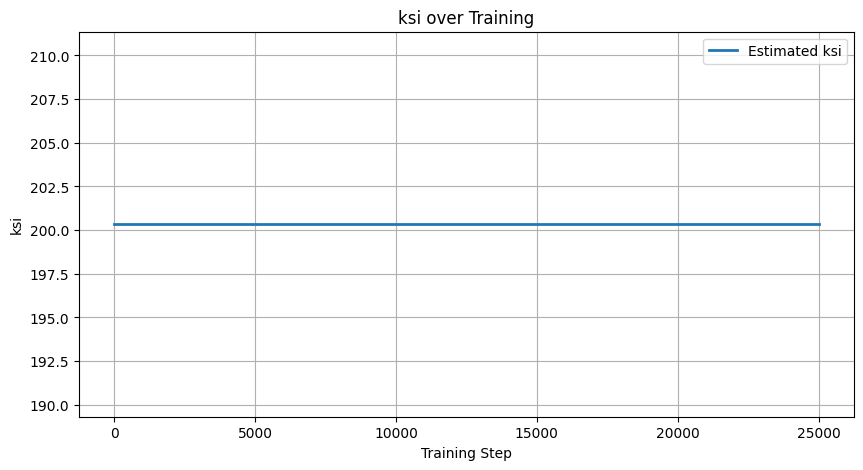

In [ ]:
# === Load & parse log file ===
import ast
dat_path = f"run_{pat}_params_stagepat.dat"  # or stage1.dat if you want early trend

steps = []
ksi_vals = []
Tu_vals = []
Tr_vals = []

with open(dat_path, "r") as file:
    for line in file:
        if "[" in line:
            parts = line.strip().split(" ", 1)
            step = int(parts[0])
            vals = ast.literal_eval(parts[1])
            steps.append(step)
            ksi_vals.append(vals[0])
            # Tu_vals.append(vals[1])
            # Tr_vals.append(vals[2])

ksi_vals = np.exp(ksi_vals)
# Tu_vals = np.exp(Tu_vals)
# Tr_vals = np.exp(Tr_vals)

# === Plotting ===
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
params = ["ksi", "Tu", "Tr"]
# true_values = [true_params["ksi"], true_params["Tu"], true_params["Tr"]]
values = [ksi_vals, Tu_vals, Tr_vals]

plt.figure(figsize=(10, 5))
plt.plot(steps, ksi_vals, label="Estimated ksi", linewidth=2)
# plt.hlines(true_params["ksi"], min(steps), max(steps), colors="r", linestyles="dashed", label="True ksi")
plt.title("ksi over Training")
plt.xlabel("Training Step")
plt.ylabel("ksi")
plt.legend()
plt.grid(True)

# **GRU BI-RNN**

In [2]:
import os
os.environ["DDE_BACKEND"] = "tensorflow"
import deepxde as dde
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import interpolate

class GlucoseModelGRU:
    def __init__(self, pat, m_t, m_g, m_i, m_d, t_start=0, t_end=None, inverse_activated=False, df=None):
        self.max_t = m_t
        self.glucose_scaling = m_g
        self.insulin_scaling = m_i
        self.digestion_scaling = m_d
        self.t_start = t_start
        self.t_end = t_end
        self.inverse_activated = inverse_activated

        self.filename = f"patient_{pat}_wide.csv"
        self.df = df

        self.load_patient_data()

        self.min_t = t_start
        self.max_t = t_end if t_end is not None else self.time_vector.max()

        if self.inverse_activated:
            self.inverse_params = self.set_inverse_parameters()
        else:
            self.set_parameters()

    def load_patient_data(self):
        if self.df is not None:
            df = self.df  # Use externally provided filtered dataframe
        else:
            df = pd.read_csv(self.filename)  # Fallback to full file (legacy path)

        self.time_vector = df["time_min"].values[:, None]

        data_g = df["glucose"].values[:, None]
        self.data_g = data_g  # assuming it's already interpolated and clipped

        self.insulin_vector = tf.convert_to_tensor(df["ut"].fillna(0).values, dtype=tf.float32)
        self.carb_vector = tf.convert_to_tensor(df["rt"].fillna(0).values, dtype=tf.float32)



    def set_parameters(self):
        self.M = 76  # kg
        self.kl = 1.85           # mg/dL/min
        self.ku_Vi = 0.060       # 1/min
        self.kr_Vb = 0.0022      # 1/min
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.ksi = 235.0
        self.Ieq = (self.kl - self.kb) / 200  # placeholder denominator
        self.Tu = 120.0
        self.Tr = 180.0

    def set_inverse_parameters(self, random_init=True):
        self.M = 76
        self.kl = 1.85
        self.ku_Vi = 0.060
        self.kr_Vb = 0.0022
        self.Vb = 0.65 * self.M
        self.Vi = 2.5 * self.M
        self.kb = 128 / self.M
        self.Tu = 120.0
        self.Tr = 180.0

        if random_init:
            init_val = np.random.uniform(156.18, 315.62)
        else:
            init_val = 235.0

        self.log_ksi = tf.Variable(tf.math.log(init_val), dtype=tf.float32, name="log_ksi")
        ksi = tf.exp(self.log_ksi)
        self.Ieq = (self.kl - self.kb) / ksi

        return self.log_ksi

    def geometry_time(self):
        return dde.geometry.TimeDomain(self.min_t, self.max_t)

    def lookup_inputs(self, t_scalar):
        """
        Fast lookup for u(t), r(t) from scalar time index.
        """
        idx = int(t_scalar)
        if 0 <= idx < len(self.insulin_vector):
            return self.insulin_vector[idx], self.carb_vector[idx]
        return 0.0, 0.0

    def generate_inputs_over_time(self, x):
        """
        Batch input generator — takes [N, 1] tensor of normalized time, returns ut, rt tensors.
        """
        t_real = tf.cast(x[:, 0:1] * tf.cast(self.max_t, tf.float32), tf.float32)
        idx = tf.cast(tf.round(t_real), tf.int32)
        idx = tf.clip_by_value(idx, 0, tf.shape(self.insulin_vector)[0] - 1)

        ut = tf.gather(self.insulin_vector, idx)
        rt = tf.gather(self.carb_vector, idx)
        return ut, rt

    def get_initial_state(self):
        g0 = self.data_g[0, 0] / self.glucose_scaling
        i0 = 0.1
        d0 = 0.0
        return tf.convert_to_tensor([[g0, i0, d0]], dtype=tf.float32)  # shape: [1, 3]

    def get_ground_truth_sequence(self):
        g = data_g / self.glucose_scaling
        i = data_i / self.insulin_scaling
        d = data_d / self.digestion_scaling
        y_seq = np.stack([g.flatten(), i.flatten(), d.flatten()], axis=-1)
        return tf.convert_to_tensor(y_seq[None, :, :], dtype=tf.float32)  # shape [1, T, 3]


    def get_input_sequences(self):
        u = tf.reshape(self.insulin_vector, [1, -1, 1])  # shape: [1, T, 1]
        r = tf.reshape(self.carb_vector, [1, -1, 1])     # shape: [1, T, 1]
        return u, r


import tensorflow as tf

class GRUDeCarliModel(tf.keras.Model):
    def __init__(self, hidden_units=64, num_layers=1, hard_ic=None):
        super(GRUDeCarliModel, self).__init__()
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.hard_ic = hard_ic  # Tensor of shape [1, 1, 3] or None

        self.gru_layers = [
            tf.keras.layers.GRU(hidden_units, return_sequences=True)
            for _ in range(num_layers)
        ]
        self.output_layer = tf.keras.layers.Dense(3, activation="linear")  # Predict G, I, D

    def call(self, inputs, training=False):
        x = inputs  # Shape: [B, T, 5] (u, r, G, I, D)

        for gru in self.gru_layers:
            x = gru(x, training=training)

        outputs = self.output_layer(x)  # Shape: [B, T, 3]

        if self.hard_ic is not None:
            T = tf.shape(outputs)[1]  # sequence length
            t = tf.linspace(0.0, 1.0, T)  # shape [T]
            t = tf.reshape(t, [1, T, 1])  # shape [1, T, 1] to broadcast
            ramp = 1 - tf.exp(-10 * t)  # or tf.tanh(t)
            outputs = self.hard_ic + ramp * outputs

        return outputs


Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Eager execution enabled: True
Epoch 0 : Total= 4.0373106 , G= 0.415643334 , I= 0.00196249527 , D= 0.00184474385 , IC= 0.0680346861 , L_B= 0.139963329
Epoch 50 : Total= 0.00767810503 , G= 0.000747886661 , I= 0.00357104186 , D= 0.00216254732 , IC= 0.000105235064 , L_B= 0.000339456397
Epoch 100 : Total= 0.000383299193 , G= 4.04933198e-05 , I= 0.00357780117 , D= 0.00217707525 , IC= 3.46162301e-06 , L_B= 1.19041306e-05
Epoch 150 : Total= 0.000245675 , G= 2.78829866e-05 , I= 0.00358424149 , D= 0.00222900626 , IC= 2.77290184e-07 , L_B= 4.64332834e-06
Epoch 200 : Total= 0.000212321698 , G= 2.45619085e-05 , I= 0.00358659541 , D= 0.00223042932 , IC= 1.53915224e-07 , L_B= 3.25206497e-06
Epoch 250 : Total= 0.000193165048 , G= 2.25680051e-05 , I= 0.00358803431 , D= 0.00222999742 , IC= 9.57207575e-08 , L_B= 2.59495437e-06
Epoch 300 : Total= 0.000179644805 , G= 2.1119642e-05 , I= 0.00358877401 , D= 0.00223011523 , IC= 6.14520275e-08 , L_B= 2.19864728e-06
Epoch 350 : Total= 0.000169143605 , G= 1.99776

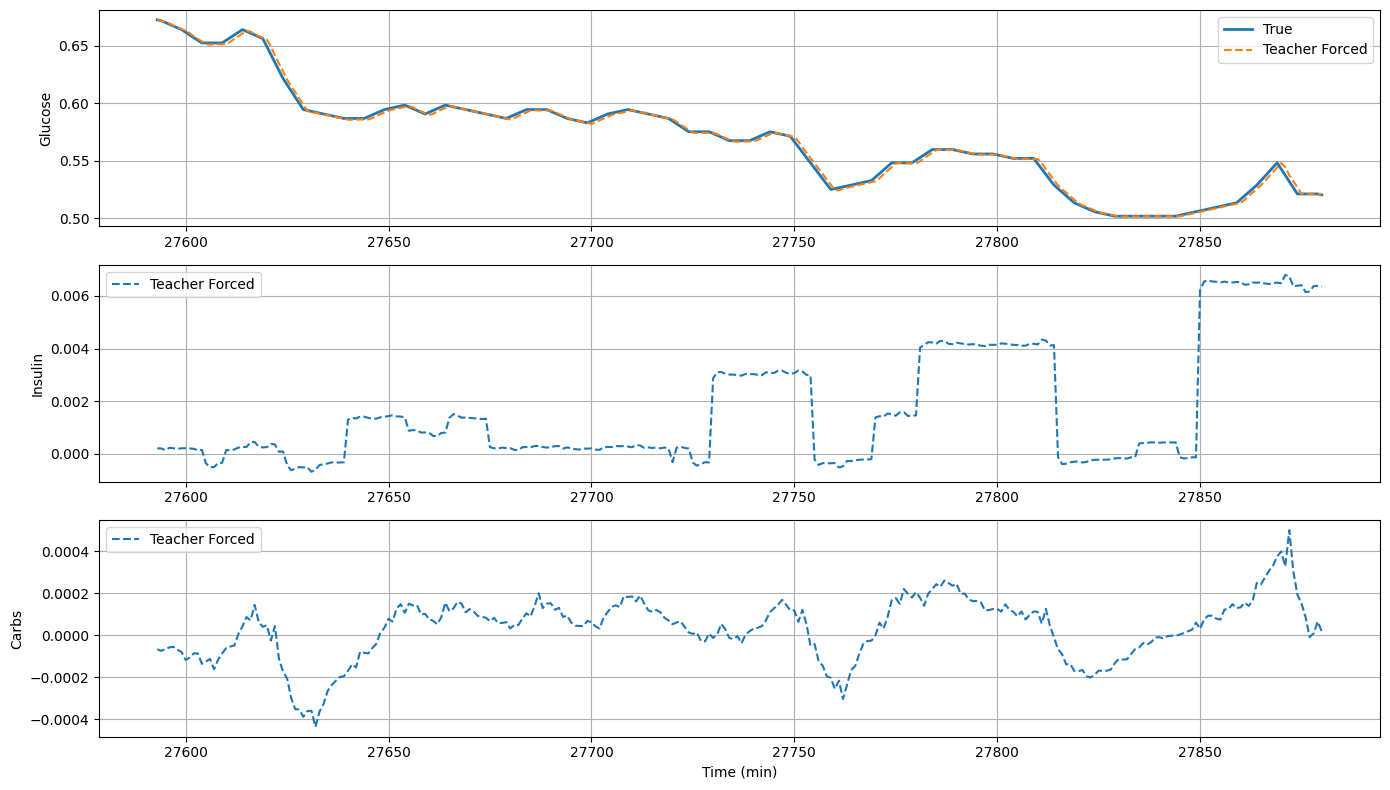

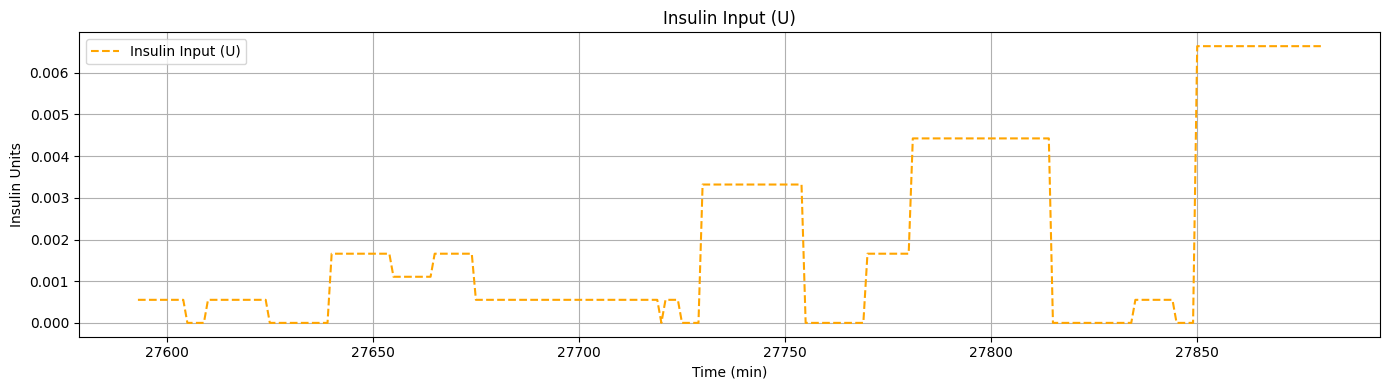

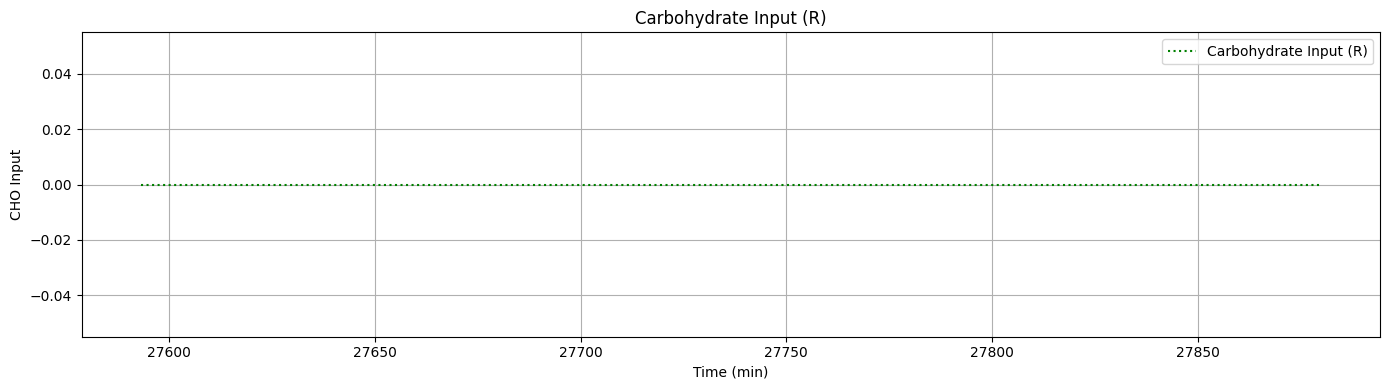

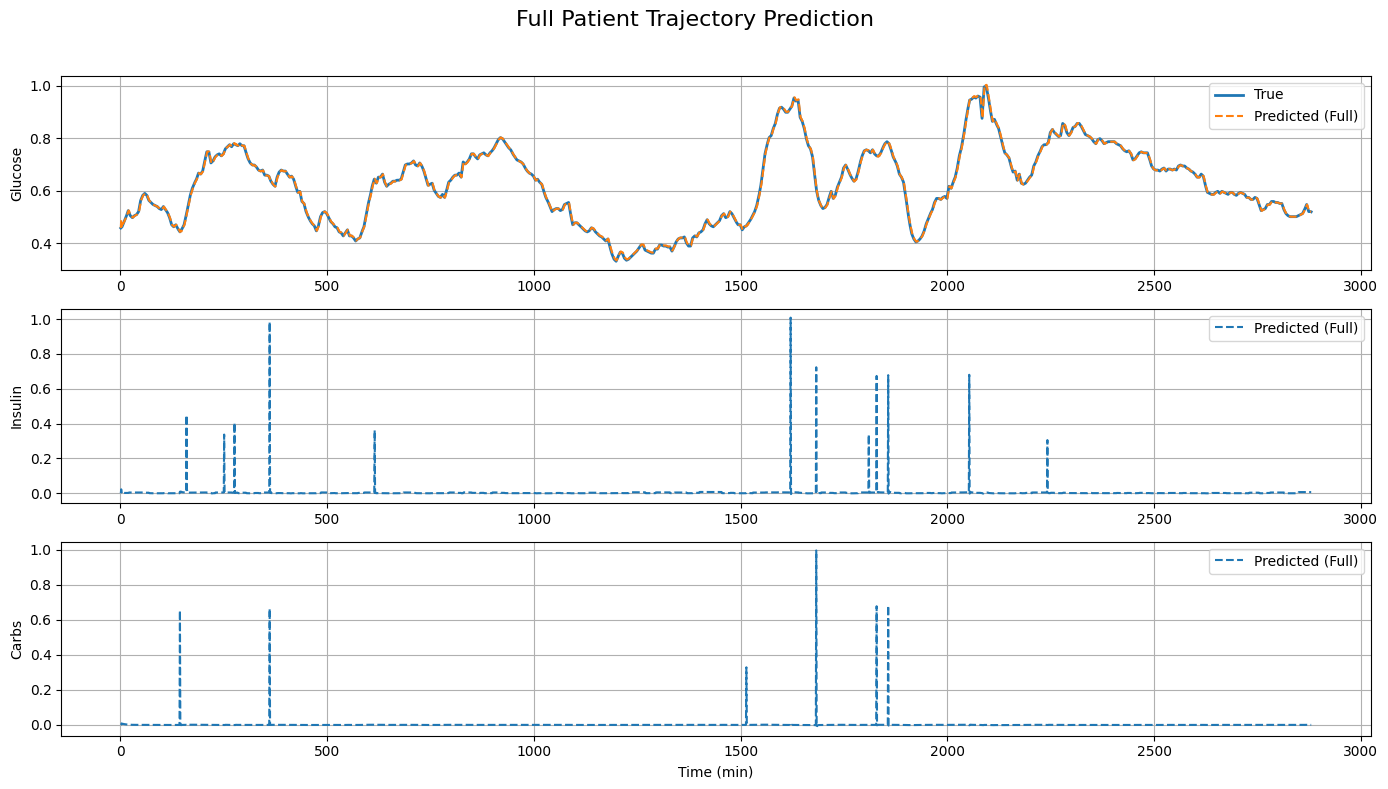

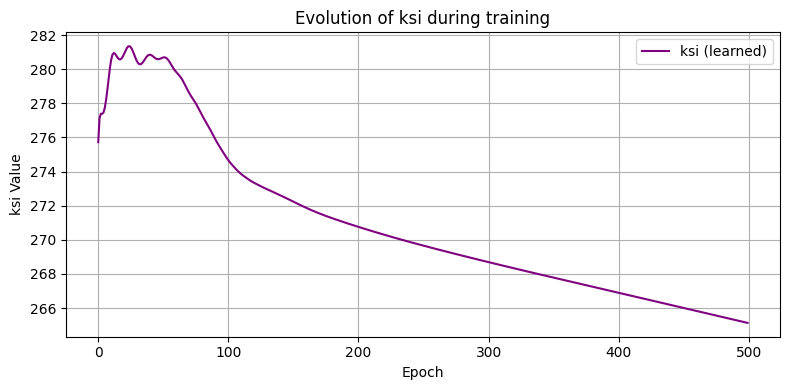

In [3]:
# === TRAINING SCRIPT FOR GRU DE CARLI MODEL (TF2.x) ===

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

print("Eager execution enabled:", tf.executing_eagerly())

# --- 1. Load data from GlucoseModel ---
pat = "60b9c27a" # "b4bdfa85"
num_epochs = 500
inverse_activated = True
# lambda_B = 1.0
# lambda_g = 0.0
# lambda_ic = 0.0
# lambda_i = 0
# lambda_d = 0

t_start = 25000
t_end = 27880

lambda_B = 4.824265766666132 # 0.25
lambda_g = 8.002287337267578 # 0.5
lambda_i = 0
lambda_d = 0
lambda_ic = 0.5290404144856771 # 0.25

t_start = 25000
t_end = 27880
# lambda_B = 1.322511861253553 # 0.25
# lambda_g = 0.790143042551918 # 0.5
# lambda_ic = 9.842348970564318 # 0.25

# === LOAD AND CLIP DATA BEFORE model_obj is built ===
os.chdir('/content/drive/My Drive/FYP/wide_format')
filename = f"patient_{pat}_wide.csv"
df = pd.read_csv(filename)

# Interpolate glucose and overwrite column
valid_idx = ~np.isnan(df["glucose"].values)
interp_func = interpolate.interp1d(
    df["time_min"].values[valid_idx],
    df["glucose"].values[valid_idx],
    kind="linear",
    fill_value="extrapolate"
)
df["glucose"] = interp_func(df["time_min"].values)

# Clip full dataframe to t_start → t_end
df = df[(df["time_min"] >= t_start) & (df["time_min"] <= t_end)].reset_index(drop=True)

# Update local data arrays from clipped df
data_t = df["time_min"].values[:, None]
data_g = df["glucose"].values[:, None]
data_i = df["ut"].values[:, None]
data_d = df["rt"].values[:, None]


# # Clip to simulation window
# data_t = data_t[mask]
# data_g = data_g[mask]
# data_i = data_i[mask]
# data_d = data_d[mask]

# Normalize
data_t = data_t - t_start
m_t = (t_end - t_start)
m_g = data_g.max()
m_i = data_i.max()
m_d = data_d.max()

data_t_normalized = data_t / m_t
data_g_normalized = data_g / m_g

model_obj = GlucoseModelGRU(pat, m_t, m_g, m_i, m_d, t_start=t_start, t_end=t_end, inverse_activated=inverse_activated, df=df)
if inverse_activated:
    inverse_vars = model_obj.set_inverse_parameters(random_init=True)
else:
    model_obj.set_parameters()

# --- 2. Retrieve sequences ---
y_true = model_obj.get_ground_truth_sequence()
u, r = model_obj.get_input_sequences()
G_only = y_true[:, :-1, 0:1]  # only glucose
Y_target = y_true[:, 1:, :]
U_seq = u[:, :-1, :] / tf.reduce_max(u[:, :-1, :] + 1e-8)
R_seq = r[:, :-1, :] / tf.reduce_max(r[:, :-1, :] + 1e-8)

X_input = tf.concat([U_seq, R_seq, G_only], axis=-1)

# --- 3. Train-test split ---
T_total = X_input.shape[1]
T_train = int(0.9 * T_total)

X_train = X_input[:, :T_train, :]
Y_train = Y_target[:, :T_train, :]
U_train = U_seq[:, :T_train, :]
R_train = R_seq[:, :T_train, :]

X_test = X_input[:, T_train:, :]
Y_test = Y_target[:, T_train:, :]
u_test = U_seq[:, T_train:, :]
r_test = R_seq[:, T_train:, :]

# --- 4. Build model ---
# hard_ic = y_true[:, 0:1, :]  # shape [1, 1, 3]
hard_ic = None
model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=hard_ic)
optimizer = Adam(learning_rate=1e-2)

# --- 5. Biological residual ---
def compute_bio_residual_loss(y_pred, y_in, u_in, r_in, dt):
    y_pred = tf.reshape(y_pred, [-1, 3])
    y_in = tf.reshape(y_in, [-1, 3])
    u_in = tf.reshape(u_in, [-1, 1])
    r_in = tf.reshape(r_in, [-1, 1])

    G, I, D = y_in[:, 0:1] * m_g, y_in[:, 1:2] * m_i, y_in[:, 2:3] * m_d
    ut = u_in * tf.reduce_max(u_in + 1e-8)
    rt = r_in * tf.reduce_max(r_in + 1e-8)

    ksi = tf.exp(model_obj.log_ksi) if inverse_activated else model_obj.ksi
    dG = (-ksi * I + model_obj.kl - model_obj.kb + D)
    dI = -I / model_obj.Tu + (model_obj.ku_Vi / model_obj.Tu) * ut
    dD = -D / model_obj.Tr + (model_obj.kr_Vb / model_obj.Tr) * rt

    y_next_ode = y_in + dt * tf.concat([dG / m_g, dI / m_i, dD / m_d], axis=1)
    return tf.reduce_mean(tf.square(y_next_ode - y_pred))

# --- 6. Training loop ---
def train_step(x, y_true, y_in, u, r):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        if model.hard_ic is not None:
            loss_ic = 0.0
        else:
            ic_true = y_true[:, 0:1, :]
            ic_pred = y_pred[:, 0:1, :]
            loss_ic = tf.reduce_mean(tf.square(ic_true - ic_pred))

        loss_g = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0]))
        loss_i = tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))
        loss_d = tf.reduce_mean(tf.square(y_true[:, :, 2] - y_pred[:, :, 2]))

        loss_bio = compute_bio_residual_loss(y_pred, y_in, u, r, dt=1.0 / m_t)

        loss = (
            lambda_g * loss_g +
            lambda_i * loss_i +
            lambda_d * loss_d +
            lambda_ic * loss_ic +
            lambda_B * loss_bio
        )

    variables = model.trainable_variables
    if inverse_activated:
        variables += [model_obj.log_ksi]
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss, loss_g, loss_i, loss_d, loss_ic, loss_bio


ksi_values = []
for epoch in range(num_epochs):
    loss_val, lg, li, ld, lic, lb = train_step(X_train, Y_train, y_true[:, :T_train, :], U_train, R_train)

    if inverse_activated:
        ksi_values.append(tf.exp(model_obj.log_ksi).numpy())

    if epoch % 50 == 0:
        tf.print("Epoch", epoch,
                 ": Total=", loss_val,
                 ", G=", lg,
                 ", I=", li,
                 ", D=", ld,
                 ", IC=", lic,
                 ", L_B=", lb)

# # === INVERSE STAGED TRAINING SCHEME FOR GRU MODEL ===
# stage_configs = [
#     (1e-2, dict(lambda_g=1.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.0, lambda_B=0.0), 500),
#     (5e-3, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 800),
#     (5e-4, dict(lambda_g=8.0, lambda_i=0.0, lambda_d=0.0, lambda_ic=0.53, lambda_B=4.82), 600),
# ]

# ksi_values = []

# for stage, (lr, lambdas, epochs) in enumerate(stage_configs):
#     print(f"\n=== Stage {stage + 1} | LR={lr}, Epochs={epochs} ===")
#     optimizer.learning_rate.assign(lr)
#     lambda_g = lambdas["lambda_g"]
#     lambda_i = lambdas["lambda_i"]
#     lambda_d = lambdas["lambda_d"]
#     lambda_ic = lambdas["lambda_ic"]
#     lambda_B = lambdas["lambda_B"]

#     # Freeze inverse parameters if desired
#     if inverse_activated:
#         inverse_vars = [model_obj.log_ksi]
#     else:
#         inverse_vars = []

#     for epoch in range(epochs):
#         loss_val, lg, li, ld, lic, lb = train_step(
#             X_train, Y_train, y_true[:, :T_train, :], U_train, R_train
#         )

#         if inverse_activated:
#             ksi_values.append(tf.exp(model_obj.log_ksi).numpy())

#         if epoch % 50 == 0:
#             tf.print(f"[Stage {stage+1} | Epoch {epoch}]",
#                      "Total=", loss_val,
#                      ", G=", lg,
#                      ", I=", li,
#                      ", D=", ld,
#                      ", IC=", lic,
#                      ", L_B=", lb)


# --- 7. Evaluation ---
predicted_full = model(X_input, training=False).numpy()
true_full = y_true.numpy()
time_full = data_t[1:].flatten()

predicted_train = predicted_full[:, :T_train, :]
predicted_test = predicted_full[:, T_train:, :]

true_train = Y_train.numpy()
true_test = Y_test.numpy()

true_train = true_full[:, 1:T_train + 1, :]
true_test = true_full[:, T_train + 1:, :]

rmse = lambda x, y: np.sqrt(np.mean((x - y) ** 2))
rmse_G_train = rmse(predicted_train[0, :, 0], true_train[0, :, 0])


rmse_G_test = rmse(predicted_test[0, :, 0], true_test[0, :, 0])


print("\nFinal RMSE (Train):")
print(f"Glucose: {rmse_G_train:.4f}")


print("\nFinal RMSE (Test):")
print(f"Glucose: {rmse_G_test:.4f}")


# --- 8. Autoregressive Forecast Rollout ---
# def autoregressive_forecast(model, u, r, y0, steps):
#     preds = []
#     y_prev = y0
#     for t in range(steps):
#         x_t = tf.concat([u[:, t:t+1, :], r[:, t:t+1, :], y_prev[:, :, 0:1]], axis=-1)
#         y_next = model(x_t, training=False)
#         preds.append(y_next)
#         y_prev = y_next
#     return tf.concat(preds, axis=1)

# Y0 = y_true[:, :1, :]
# ar_forecast = autoregressive_forecast(model, u_test, r_test, Y0, steps=u_test.shape[1])

# --- 9. Plotting ---
time_vector = model_obj.time_vector.flatten()  # shape: (T,)
time_for_targets = time_vector[1:]             # match y_true[:, 1:, :]
time_test = time_for_targets[T_train:]         # get test window

plt.figure(figsize=(14, 8))
labels = ["Glucose", "Insulin", "Carbs"]
for i in range(3):
    plt.subplot(3, 1, i + 1)

    if i == 0:  # Only for glucose
        plt.plot(time_test, true_test[0, :, i], label="True", linewidth=2)

    plt.plot(time_test, predicted_test[0, :, i], label="Teacher Forced", linestyle="--")
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.xlabel("Time (min)")
plt.tight_layout()
plt.show()


# --- 9c. Plot Insulin Input (U) ---
plt.figure(figsize=(14, 4))
plt.plot(time_test, u_test[0, :, 0], label="Insulin Input (U)", linestyle="--", color="orange")
plt.xlabel("Time (min)")
plt.ylabel("Insulin Units")
plt.title("Insulin Input (U)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 9d. Plot Carbohydrate Input (R) ---
plt.figure(figsize=(14, 4))
plt.plot(time_test, r_test[0, :, 0], label="Carbohydrate Input (R)", linestyle=":", color="green")
plt.xlabel("Time (min)")
plt.ylabel("CHO Input")
plt.title("Carbohydrate Input (R)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 10. Plot Full Prediction vs Ground Truth ---
plt.figure(figsize=(14, 8))
labels = ["Glucose", "Insulin", "Carbs"]

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Only plot true values for glucose
    if i == 0:
        plt.plot(time_full, true_full[0, 1:, i], label="True", linewidth=2)

    plt.plot(time_full, predicted_full[0, :, i], label="Predicted (Full)", linestyle="--")
    plt.ylabel(labels[i])
    plt.legend()
    plt.grid(True)

plt.xlabel("Time (min)")
plt.suptitle("Full Patient Trajectory Prediction", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Plot ksi evolution over time ---
if inverse_activated:
    plt.figure(figsize=(8, 4))
    plt.plot(ksi_values, label="ksi (learned)", color='purple')
    plt.xlabel("Epoch")
    plt.ylabel("ksi Value")
    plt.title("Evolution of ksi during training")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


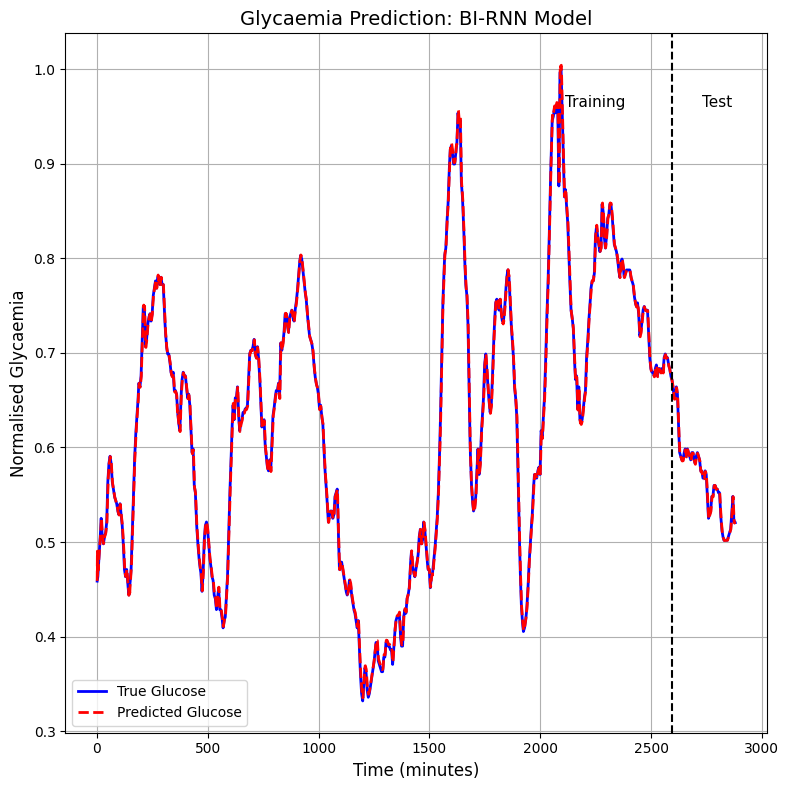

In [4]:
# === GRU Glucose Trace Plot with Train/Test Split ===

# Extract glucose only (index 0), rescale if needed
G_pred_gru = predicted_full[0, :, 0]
G_true_gru = true_full[0, 1:, 0]
time_gru = time_full

# Split index for 90% training
split_index = int(0.9 * len(G_true_gru))
split_time = time_gru[split_index]

plt.figure(figsize=(8, 8))
plt.plot(time_gru, G_true_gru, label="True Glucose", color="blue", linewidth=2)
plt.plot(time_gru, G_pred_gru, label="Predicted Glucose", linestyle="--", color="red", linewidth=2)

# Add vertical dashed line at test/train split
plt.axvline(x=split_time, color='black', linestyle='--', linewidth=1.5)
plt.text(2250, 0.96, 'Training', ha='center', fontsize=11)
plt.text(2800, 0.96, 'Test', ha='center', fontsize=11)

# Labels and formatting
plt.xlabel("Time (minutes)", fontsize=12)
plt.ylabel("Normalised Glycaemia", fontsize=12)
plt.title("Glycaemia Prediction: BI-RNN Model", fontsize=14)
plt.legend(loc="lower left", frameon=True, fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("REALglucose_prediction_GRU.png", dpi=600, bbox_inches='tight')
plt.show()


In [6]:
from sklearn.metrics import mean_squared_error
import math

patients = ("60b9c27a", "b4bdfa85", "46f119e5", "47b5aa6b", "ab993210")
num_runs = 5
num_epochs = 500
ksi_records = []

for pat in patients:
    for run in range(num_runs):
        print(f"\n=== Patient {pat} | Run {run + 1} / {num_runs} ===")

        os.chdir('/content/drive/My Drive/FYP/wide_format')
        filename = f"patient_{pat}_wide.csv"
        df = pd.read_csv(filename)

        # Interpolate glucose and overwrite column
        valid_idx = ~np.isnan(df["glucose"].values)
        interp_func = interpolate.interp1d(
            df["time_min"].values[valid_idx],
            df["glucose"].values[valid_idx],
            kind="linear",
            fill_value="extrapolate"
        )
        df["glucose"] = interp_func(df["time_min"].values)

        # Clip full dataframe to t_start → t_end
        df = df[(df["time_min"] >= t_start) & (df["time_min"] <= t_end)].reset_index(drop=True)

        # Update local data arrays from clipped df
        data_t = df["time_min"].values[:, None]
        data_g = df["glucose"].values[:, None]
        data_i = df["ut"].values[:, None]
        data_d = df["rt"].values[:, None]


        # # Clip to simulation window
        # data_t = data_t[mask]
        # data_g = data_g[mask]
        # data_i = data_i[mask]
        # data_d = data_d[mask]

        # Normalize
        data_t = data_t - t_start
        m_t = (t_end - t_start)
        m_g = data_g.max()
        m_i = data_i.max()
        m_d = data_d.max()

        data_t_normalized = data_t / m_t
        data_g_normalized = data_g / m_g
        # Load patient data


        # Build model_obj
        model_obj = GlucoseModelGRU(pat, m_t, m_g, m_i, m_d, t_start=t_start, t_end=t_end, inverse_activated=inverse_activated, df=df)
        if inverse_activated:
            model_obj.set_inverse_parameters()
            initial_ksi = tf.exp(model_obj.log_ksi).numpy()
        else:
            model_obj.set_parameters(pat)
            initial_ksi = model_obj.ksi

        # --- 2. Retrieve sequences ---
        y_true = model_obj.get_ground_truth_sequence()
        u, r = model_obj.get_input_sequences()
        G_only = y_true[:, :-1, 0:1]
        Y_target = y_true[:, 1:, :]
        U_seq = u[:, :-1, :] / tf.reduce_max(u[:, :-1, :] + 1e-8)
        R_seq = r[:, :-1, :] / tf.reduce_max(r[:, :-1, :] + 1e-8)
        X_input = tf.concat([U_seq, R_seq, G_only], axis=-1)

        # --- 3. Train-test split ---
        T_total = X_input.shape[1]
        T_train = int(0.8 * T_total)

        X_train = X_input[:, :T_train, :]
        Y_train = Y_target[:, :T_train, :]
        U_train = U_seq[:, :T_train, :]
        R_train = R_seq[:, :T_train, :]

        X_test = X_input[:, T_train:, :]
        Y_test = Y_target[:, T_train:, :]

        # --- 4. Build model ---
        model = GRUDeCarliModel(hidden_units=96, num_layers=1, hard_ic=None)
        optimizer = Adam(learning_rate=1e-2)

        # === TRAIN ===
        for epoch in range(num_epochs):
            loss_val, lg, li, ld, lic, lb = train_step(X_train, Y_train, y_true[:, :T_train, :], U_train, R_train)
            if epoch % 50 == 0:
                tf.print("Epoch", epoch,
                         ": Total=", loss_val,
                         ", G=", lg,
                         ", I=", li,
                         ", D=", ld,
                         ", IC=", lic,
                         ", L_B=", lb)

        # === EVALUATE ===
        final_ksi = tf.exp(model_obj.log_ksi).numpy() if inverse_activated else model_obj.ksi
        Y_pred_full = model.predict(X_input)
        Y_true_full = Y_target.numpy()  # matches shape of Y_pred_full

        # Extract test region from full prediction
        G_pred = Y_pred_full[:, T_train:, 0]
        I_pred = Y_pred_full[:, T_train:, 1]
        D_pred = Y_pred_full[:, T_train:, 2]

        G_true = Y_true_full[:, T_train:, 0]


        rmse_g = math.sqrt(mean_squared_error(G_true.flatten(), G_pred.flatten()))

        ksi_records.append({
            "Patient": pat,
            "Run": run + 1,
            "Initial_ksi": float(initial_ksi),
            "Final_ksi": float(final_ksi),
            "RMSE_G": float(rmse_g)
        })

ksi_df = pd.DataFrame(ksi_records)
ksi_df.to_csv("RealBIRNNrmse_results.csv", index=False)
print("\nSaved ksi estimates to 'gru_ksi_estimates_all_patients.csv'")


=== Patient 60b9c27a | Run 1 / 5 ===
Epoch 0 : Total= 4.21118355 , G= 0.432485938 , I= 0.00771722384 , D= 0.00195699325 , IC= 0.0752771571 , L_B= 0.147272676
Epoch 50 : Total= 0.0106437672 , G= 0.00102494238 , I= 0.00406199461 , D= 0.0025534546 , IC= 0.000110084722 , L_B= 0.000494094682
Epoch 100 : Total= 0.000436463626 , G= 4.67254e-05 , I= 0.00391693367 , D= 0.00249364 , IC= 3.58300917e-06 , L_B= 1.25735187e-05
Epoch 150 : Total= 0.000286309427 , G= 3.26862319e-05 , I= 0.00403208751 , D= 0.0025124664 , IC= 3.58238964e-07 , L_B= 5.08995754e-06
Epoch 200 : Total= 0.000242698181 , G= 2.79342639e-05 , I= 0.00403384445 , D= 0.00250640232 , IC= 1.58934242e-07 , L_B= 3.9542e-06
Epoch 250 : Total= 0.000218101894 , G= 2.52164482e-05 , I= 0.00403649546 , D= 0.00250625215 , IC= 5.90280536e-08 , L_B= 3.37490019e-06
Epoch 300 : Total= 0.000200736744 , G= 2.32845559e-05 , I= 0.00403720466 , D= 0.00250543328 , IC= 3.10383257e-08 , L_B= 2.98296914e-06
Epoch 350 : Total= 0.000187054931 , G= 2.174721

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

=== Patient b4bdfa85 | Run 1 / 5 ===
Epoch 0 : Total= 2.29166555 , G= 0.232725322 , I= 0.00357870385 , D= 0.00604320876 , IC= 0.0754749551 , L_B= 0.0807172135
Epoch 50 : Total= 0.000673789764 , G= 5.43458809e-05 , I= 0.00295061548 , D= 0.00318553578 , IC= 8.28095581e-05 , L_B= 4.04390812e-05
Epoch 100 : Total= 0.000262119371 , G= 2.8786515e-05 , I= 0.00306570507 , D= 0.0031979247 , IC= 7.41105623e-07 , L_B= 6.50241e-06
Epoch 150 : Total= 0.000216051631 , G= 2.4062143e-05 , I= 0.00308465678 , D= 0.00320648751 , IC= 1.93248653e-08 , L_B= 4.86897716e-06
Epoch 200 : Total= 0.000185075405 , G= 2.06871846e-05 , I= 0.00308360346 , D= 0.00320721767 , IC= 1.28677415e-08 , L_B= 4.04700222e-06
Epoch 250 : Total= 0.000161356264 , G= 1.80539791e-05 , I= 0.00308254268 , D= 0.00320670637 , IC= 1.11012506e-08 , L_B= 3.49841093e-06
Epoch 300 : Total= 0.000143112877 , G= 1.60263207e-05 , I= 0.00308191613 , D= 0.00320673105 , IC= 9.58084723e-09 , L_B= 3.08038284e-0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step

=== Patient b4bdfa85 | Run 2 / 5 ===
Epoch 0 : Total= 2.61798644 , G= 0.267173856 , I= 0.00154348009 , D= 0.00281297881 , IC= 0.0813193545 , L_B= 0.0905761197
Epoch 50 : Total= 0.00216694409 , G= 0.000188228965 , I= 0.00261347205 , D= 0.0032566078 , IC= 0.000166562852 , L_B= 0.000118684067
Epoch 100 : Total= 0.000294845 , G= 3.21698099e-05 , I= 0.0031110167 , D= 0.00322165829 , IC= 2.50963262e-06 , L_B= 7.47995e-06
Epoch 150 : Total= 0.000239069792 , G= 2.72109555e-05 , I= 0.00308648241 , D= 0.00320881233 , IC= 1.97937553e-07 , L_B= 4.39760333e-06
Epoch 200 : Total= 0.000210566795 , G= 2.42406677e-05 , I= 0.00308421906 , D= 0.00320665538 , IC= 8.59594138e-08 , L_B= 3.42861063e-06
Epoch 250 : Total= 0.000188977283 , G= 2.19171779e-05 , I= 0.00308541651 , D= 0.00320651894 , IC= 5.81216817e-08 , L_B= 2.81058033e-06
Epoch 300 : Total= 0.000171252032 , G= 1.99705009e-05 , I= 0.00308611616 , D= 0.00320589356 , IC= 4.0402643e-08 , L_B= 2.36740493e-06
Ep

# **Inverse Parameter Sweep**

In [ ]:
ksi_range = np.arange(180.0, 281.0, 10.0)
glucose_predictions = []
rmse_values = []

for ksi_val in ksi_range:
    print(f"\n=== Simulating with ksi = {ksi_val} ===")

    # Set fixed ksi
    glucosemodel.set_parameters()
    glucosemodel.ksi = ksi_val  # Overwrite default
    glucosemodel.Ieq = (glucosemodel.kl - glucosemodel.kb) / glucosemodel.ksi
    # glucosemodel.generate_inputs_over_time()  # Regenerate ut/rt for current ksi

    # Rebuild model
    geomtime = glucosemodel.geometry_time()
    ode_data = dde.data.PDE(geomtime, glucosemodel.ode, input_data,
                            num_domain=num_domain, anchors=t_train, num_test=num_test)

    net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size],
                       "tanh", "Glorot uniform")

    if ini_con == 'hard':
        net.apply_output_transform(lambda t, y: tf.concat([
            tf.nn.relu(y[:, 0:1] * tf.tanh(t) + func_init[0]),
            tf.nn.relu(y[:, 1:2] * tf.tanh(t) + func_init[1]),
            tf.nn.relu(y[:, 2:3] * tf.tanh(t) + func_init[2]),
        ], axis=1))

    if fourier:
        net.apply_feature_transform(lambda t: tf.concat(
            [t * m_t] +
            [tf.sin(2**k * np.pi * t * m_t / 500) for k in range(6)] +
            [tf.cos(2**k * np.pi * t * m_t / 500) for k in range(6)],
            axis=1
        ))

    model = dde.Model(ode_data, net)
    model.compile("adam", lr=lr, loss_weights=[8.231071303389253, 1.9036850712556335, 2.722477081151682, 0.008058721484394595])
    model.train(epochs=30000, display_every=1000)

    G_pred = model.predict(data_t_normalized)[:, 0]
    glucose_predictions.append(G_pred)

    G_true = data_g_normalized.squeeze()
    rmse = np.sqrt(np.mean((G_pred - G_true)**2))
    rmse_values.append(rmse)
    print(f"RMSE for ksi = {ksi_val:.0f}: {rmse:.5f}")

plt.figure(figsize=(12, 6))
for i, G in enumerate(glucose_predictions):
    plt.plot(data_t, G, label=f"ksi = {ksi_range[i]:.0f}")

plt.plot(data_t, data_g_normalized, 'k--', label="True Glucose")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Traces for Varying ksi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ksi_range, rmse_values, marker='o', linestyle='-', color='purple')
plt.xlabel("Insulin Sensitivity (ksi)")
plt.ylabel("Glucose RMSE")
plt.title("RMSE of Glucose Prediction vs ksi")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
for i, G in enumerate(glucose_predictions):
    plt.plot(data_t, G, label=f"ksi = {ksi_range[i]:.0f}")

plt.plot(data_t, data_g_normalized, 'k--', label="True Glucose")
plt.xlabel("Time (minutes)")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Traces for Varying ksi")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ksi_range, rmse_values, marker='o', linestyle='-', color='purple')
plt.xlabel("Insulin Sensitivity (ksi)")
plt.ylabel("Glucose RMSE")
plt.title("RMSE of Glucose Prediction vs ksi")
plt.grid(True)
plt.tight_layout()
plt.show()

# **Bayesian Optimisation**

In [ ]:
import sys
import os
import csv
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import argparse
import numpy as np
import pandas as pd
import deepxde as dde
import optuna  # Import Optuna for Bayesian Optimization

# model = dde.Model(ode_data, net)

# Function for Bayesian Optimization
def objective(trial):
    tf.keras.backend.clear_session()

    # Rebuild physical model and time geometry
    glucosemodel = GlucoseModel(pat, m_t, m_g, m_i, m_d, t_start, t_end)
    geomtime = glucosemodel.geometry_time()

    # Rebuild loss weights
    loss_weights = [trial.suggest_float(f'loss_weight_{i}', 0, 50.0) for i in range(4)]

    # Rebuild the neural network
    # net = dde.maps.FNN([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size], "tanh", "Glorot uniform")
    net = ModifiedMLP([input_size] + [hidden_layer_size] * num_hidden_layers + [output_size])

    # ode_data = dde.data.PDE(geomtime, ode, input_data,
    #                         num_domain=num_domain,
    #                         anchors=t_train,
    #                         num_test=num_test)
    # Recreate BC (important!)
    observe_g = dde.PointSetBC(t_train, g_train, component=0)
    ode_data = dde.data.PDE(
        geomtime,
        glucosemodel.ode,
        [observe_g],
        num_domain=num_domain,
        anchors=t_train,
        num_test=num_test
    )

    model = dde.Model(ode_data, net)
    model.compile("adam", loss_weights=loss_weights, lr=lr)
    losshistory, _ = model.train(epochs=5000, display_every=1000)

    # Evaluate model
    G_pred = model.predict(t_fc)[:, 0:1]

    rmse_G = np.sqrt(np.square(G_pred - g_fc).mean())

    return rmse_G


# Define the pruner (stops bad trials early)
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2500)  # Wait 2500 steps before pruning

# Create Optuna study with Bayesian Optimization & Pruning
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(n_startup_trials=50),  # First 10 trials = random search
    pruner=pruner  # Enable pruning
)

study.optimize(objective, n_trials=200)  # 100 trials

# Get optimal loss weights
best_loss_weights = [study.best_trial.params[f'loss_weight_{i}'] for i in range(4)]
print("Optimal Loss Weights:", best_loss_weights)

# Train Final Model with Best Loss Weights
model.compile("adam", loss_weights=best_loss_weights, lr=lr)
losshistory, train_state = model.train(epochs=epochs, display_every=1000)

# Compute Final RMSE
G_pred_test = model.predict(t_test)[:, 0:1]
I_pred_test = model.predict(t_test)[:, 1:2]
D_pred_test = model.predict(t_test)[:, 2:3]

rmse_G_test = np.sqrt(np.square(G_pred_test - g_test).mean())
rmse_I_test = np.sqrt(np.square(I_pred_test - i_test).mean())
rmse_D_test = np.sqrt(np.square(D_pred_test - d_test).mean())

print('Final Optimized RMSE:')
print('Glucose RMSE:', rmse_G_test)
print('Insulin RMSE:', rmse_I_test)
print('Carbohydrate RMSE:', rmse_D_test)



[I 2025-05-31 11:54:54,436] A new study created in memory with name: no-name-d25897f3-c373-4004-99de-19aea6729322


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.868503 s

Training model...

0         [7.08e-01, 7.82e-05, 4.27e-08, 2.90e+00]    [1.20e+00, 1.32e-04, 7.50e-08, 2.90e+00]    []  
1000      [7.18e-04, 1.18e-06, 6.36e-08, 3.61e-01]    [1.20e-04, 2.04e-06, 1.10e-07, 3.61e-01]    []  
2000      [5.62e-05, 6.97e-07, 4.31e-08, 1.64e-01]    [4.81e-06, 1.20e-06, 7.44e-08, 1.64e-01]    []  
3000      [7.49e-06, 6.05e-07, 3.90e-08, 1.55e-01]    [1.78e-08, 1.04e-06, 6.72e-08, 1.55e-01]    []  
4000      [1.09e-06, 6.05e-07, 3.91e-08, 1.55e-01]    [8.65e-10, 1.04e-06, 6.74e-08, 1.55e-01]    []  
5000      [2.50e-07, 6.06e-07, 3.92e-08, 1.55e-01]    [4.08e-13, 1.04e-06, 6.75e-08, 1.55e-01]    []  

Best model at step 5000:
  train loss: 1.55e-01
  test loss: 1.55e-01
  test metric: []

'train' took 68.214164 s



[I 2025-05-31 11:56:08,757] Trial 0 finished with value: 0.15755719381384903 and parameters: {'loss_weight_0': 45.74383062024065, 'loss_weight_1': 4.987254853044432, 'loss_weight_2': 41.82822591104782, 'loss_weight_3': 7.586297608069847}. Best is trial 0 with value: 0.15755719381384903.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.345414 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.41e-02, 2.85e-03, 4.61e-09, 1.30e+00]    [4.26e-02, 5.03e-03, 8.19e-09, 1.30e+00]    []  
1000      [6.46e-05, 6.44e-06, 1.35e-08, 1.93e-01]    [7.37e-06, 2.38e-07, 2.29e-08, 1.93e-01]    []  
2000      [3.53e-05, 4.94e-06, 1.06e-08, 1.18e-01]    [3.51e-07, 2.20e-06, 1.83e-08, 1.18e-01]    []  
3000      [9.84e-06, 1.99e-06, 1.03e-08, 1.14e-01]    [5.01e-08, 1.81e-06, 1.80e-08, 1.14e-01]    []  
4000      [1.81e-06, 9.33e-07, 9.97e-09, 1.08e-01]    [2.14e-08, 1.42e-06, 1.74e-08, 1.08e-01]    []  
5000      [4.12e-06, 1.04e-06, 8.30e-09, 9.48e-02]    [1.04e-08, 1.19e-06, 1.44e-08, 9.48e-02]    []  

Best model at step 5000:
  train loss: 9.48e-02
  test loss: 9.48e-02
  test metric: []

'train' took 67.915444 s



[I 2025-05-31 11:57:22,220] Trial 1 finished with value: 0.1640165022295244 and parameters: {'loss_weight_0': 0.3436298299916374, 'loss_weight_1': 34.55440704211422, 'loss_weight_2': 46.88297165743502, 'loss_weight_3': 5.765419332812494}. Best is trial 0 with value: 0.15755719381384903.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.174079 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.33e-01, 2.62e-04, 5.03e-08, 3.43e+00]    [1.07e+00, 4.45e-04, 8.79e-08, 3.43e+00]    []  
1000      [4.52e-04, 1.54e-06, 5.29e-08, 4.52e-01]    [3.89e-05, 2.24e-06, 9.16e-08, 4.52e-01]    []  
2000      [1.94e-04, 1.55e-06, 5.18e-08, 3.99e-01]    [3.76e-07, 2.58e-06, 8.96e-08, 3.99e-01]    []  
3000      [4.41e-05, 1.50e-06, 5.21e-08, 3.89e-01]    [9.54e-08, 2.58e-06, 9.02e-08, 3.89e-01]    []  
4000      [2.10e-05, 1.51e-06, 5.26e-08, 3.68e-01]    [4.85e-09, 2.58e-06, 9.11e-08, 3.68e-01]    []  
5000      [2.95e-05, 1.51e-06, 5.05e-08, 3.24e-01]    [2.74e-06, 2.58e-06, 8.73e-08, 3.24e-01]    []  

Best model at step 5000:
  train loss: 3.24e-01
  test loss: 3.24e-01
  test metric: []

'train' took 67.780390 s



[I 2025-05-31 11:58:35,358] Trial 2 finished with value: 0.16386837082009403 and parameters: {'loss_weight_0': 36.971255578943286, 'loss_weight_1': 10.892150942537027, 'loss_weight_2': 47.530784089232746, 'loss_weight_3': 19.42570155100729}. Best is trial 0 with value: 0.15755719381384903.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.064112 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.74e-01, 2.37e-04, 9.62e-08, 4.61e-01]    [3.06e-01, 4.16e-04, 1.67e-07, 4.61e-01]    []  
1000      [4.91e-04, 4.66e-06, 1.09e-07, 8.11e-02]    [3.67e-06, 7.33e-06, 1.89e-07, 8.11e-02]    []  
2000      [3.64e-04, 5.36e-06, 1.25e-07, 4.36e-02]    [3.22e-07, 8.93e-06, 2.17e-07, 4.36e-02]    []  
3000      [1.23e-05, 5.04e-06, 1.24e-07, 4.34e-02]    [5.89e-09, 8.76e-06, 2.16e-07, 4.34e-02]    []  
4000      [1.37e-07, 4.93e-06, 1.22e-07, 4.32e-02]    [5.15e-09, 8.55e-06, 2.11e-07, 4.32e-02]    []  
5000      [8.96e-07, 4.73e-06, 1.17e-07, 4.29e-02]    [2.01e-09, 8.21e-06, 2.03e-07, 4.29e-02]    []  

Best model at step 5000:
  train loss: 4.29e-02
  test loss: 4.29e-02
  test metric: []

'train' took 66.997472 s



[I 2025-05-31 11:59:48,606] Trial 3 finished with value: 0.1576455826303546 and parameters: {'loss_weight_0': 14.331631354469287, 'loss_weight_1': 12.313932625881636, 'loss_weight_2': 37.9540132334835, 'loss_weight_3': 2.105946941975229}. Best is trial 0 with value: 0.15755719381384903.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.103785 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.64e-01, 1.80e-04, 1.35e-09, 8.45e+00]    [4.51e-01, 3.08e-04, 2.38e-09, 8.45e+00]    []  
1000      [5.72e-04, 5.19e-07, 2.12e-10, 7.51e-01]    [3.06e-06, 1.18e-07, 3.10e-10, 7.51e-01]    []  
2000      [4.38e-04, 5.42e-07, 6.38e-10, 3.58e-01]    [7.86e-06, 3.86e-07, 1.04e-09, 3.58e-01]    []  
3000      [2.09e-04, 5.40e-07, 8.68e-10, 3.21e-01]    [6.77e-07, 6.20e-07, 1.44e-09, 3.21e-01]    []  
4000      [4.26e-05, 4.46e-07, 9.05e-10, 3.19e-01]    [9.73e-08, 6.66e-07, 1.50e-09, 3.19e-01]    []  
5000      [7.07e-06, 4.41e-07, 9.63e-10, 3.16e-01]    [1.60e-08, 7.18e-07, 1.60e-09, 3.16e-01]    []  

Best model at step 5000:
  train loss: 3.16e-01
  test loss: 3.16e-01
  test metric: []

'train' took 67.679854 s



[I 2025-05-31 12:01:01,632] Trial 4 finished with value: 0.1563882433206396 and parameters: {'loss_weight_0': 35.083777148250824, 'loss_weight_1': 17.591951855363952, 'loss_weight_2': 5.177416672105506, 'loss_weight_3': 15.579349828926848}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.857054 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [5.49e-01, 9.62e-04, 2.28e-10, 8.31e-01]    [9.20e-01, 1.61e-03, 5.71e-11, 8.31e-01]    []  
1000      [1.77e-03, 4.23e-06, 1.95e-08, 5.64e-02]    [1.25e-05, 1.68e-06, 3.40e-08, 5.64e-02]    []  
2000      [8.27e-04, 2.96e-06, 2.56e-08, 3.29e-02]    [3.90e-06, 2.47e-06, 4.46e-08, 3.29e-02]    []  
3000      [1.72e-04, 2.12e-06, 2.96e-08, 2.67e-02]    [6.33e-07, 3.06e-06, 5.16e-08, 2.67e-02]    []  
4000      [8.13e-06, 1.82e-06, 2.94e-08, 2.65e-02]    [3.67e-08, 3.13e-06, 5.13e-08, 2.65e-02]    []  
5000      [9.43e-07, 1.75e-06, 2.84e-08, 2.65e-02]    [9.72e-09, 3.05e-06, 4.97e-08, 2.65e-02]    []  

Best model at step 5000:
  train loss: 2.65e-02
  test loss: 2.65e-02
  test metric: []

'train' took 67.508007 s



[I 2025-05-31 12:02:15,330] Trial 5 finished with value: 0.15723627439134183 and parameters: {'loss_weight_0': 16.15010256756584, 'loss_weight_1': 23.481998775180173, 'loss_weight_2': 46.933468743519185, 'loss_weight_3': 1.2975151454559686}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.222831 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.08e-04, 1.03e-05, 1.64e-09, 2.55e+00]    [8.23e-05, 2.28e-06, 2.75e-09, 2.55e+00]    []  
1000      [5.49e-05, 3.86e-06, 2.07e-09, 3.36e-01]    [3.92e-06, 1.64e-06, 3.66e-09, 3.36e-01]    []  
2000      [5.57e-06, 6.37e-07, 1.95e-09, 3.23e-01]    [3.05e-08, 5.40e-07, 3.46e-09, 3.23e-01]    []  
3000      [1.63e-06, 3.69e-07, 1.30e-09, 3.17e-01]    [6.15e-08, 4.68e-07, 2.28e-09, 3.17e-01]    []  
4000      [1.48e-07, 1.11e-07, 4.79e-10, 3.09e-01]    [3.68e-08, 1.10e-07, 7.37e-10, 3.09e-01]    []  
5000      [1.59e-05, 1.33e-06, 5.55e-10, 2.79e-01]    [1.17e-07, 8.73e-10, 2.95e-12, 2.79e-01]    []  

Best model at step 5000:
  train loss: 2.79e-01
  test loss: 2.79e-01
  test metric: []

'train' took 67.702958 s



[I 2025-05-31 12:03:28,624] Trial 6 finished with value: 0.1608751942790819 and parameters: {'loss_weight_0': 0.7582353397674768, 'loss_weight_1': 36.95693345070117, 'loss_weight_2': 24.809941700773503, 'loss_weight_3': 15.754423525071498}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.172725 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.86e-01, 1.04e-03, 9.44e-09, 8.87e+00]    [1.33e+00, 1.76e-03, 1.59e-08, 8.87e+00]    []  
1000      [2.20e-03, 5.64e-06, 2.27e-08, 8.58e-01]    [5.10e-04, 3.81e-06, 3.91e-08, 8.58e-01]    []  
2000      [3.94e-04, 4.34e-06, 2.09e-08, 5.20e-01]    [4.39e-07, 6.76e-06, 3.59e-08, 5.20e-01]    []  
3000      [1.98e-04, 4.21e-06, 2.11e-08, 5.02e-01]    [1.93e-06, 7.16e-06, 3.60e-08, 5.02e-01]    []  
4000      [3.39e-04, 4.74e-06, 2.32e-08, 4.67e-01]    [2.31e-07, 7.52e-06, 3.87e-08, 4.67e-01]    []  
5000      [3.14e-04, 5.61e-06, 2.76e-08, 4.23e-01]    [6.72e-07, 8.26e-06, 4.38e-08, 4.23e-01]    []  

Best model at step 5000:
  train loss: 4.23e-01
  test loss: 4.23e-01
  test metric: []

'train' took 69.131255 s



[I 2025-05-31 12:04:43,370] Trial 7 finished with value: 0.16404652976179154 and parameters: {'loss_weight_0': 46.482659159550884, 'loss_weight_1': 46.96798753993393, 'loss_weight_2': 30.205538634242927, 'loss_weight_3': 25.261595300986162}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.929428 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.67e+00, 2.38e-03, 1.82e-08, 2.36e+01]    [2.81e+00, 4.00e-03, 3.06e-08, 2.36e+01]    []  
1000      [9.40e-03, 2.65e-05, 2.89e-08, 1.22e+00]    [7.35e-04, 1.63e-05, 4.92e-08, 1.22e+00]    []  
2000      [2.26e-03, 2.06e-05, 3.40e-08, 6.65e-01]    [8.88e-05, 2.57e-05, 5.77e-08, 6.65e-01]    []  
3000      [1.01e-03, 1.98e-05, 3.58e-08, 6.06e-01]    [4.31e-06, 2.99e-05, 6.05e-08, 6.06e-01]    []  
4000      [6.47e-04, 1.92e-05, 3.58e-08, 6.03e-01]    [1.27e-06, 3.02e-05, 6.04e-08, 6.03e-01]    []  
5000      [2.60e-04, 1.80e-05, 3.59e-08, 5.95e-01]    [1.16e-05, 2.94e-05, 6.06e-08, 5.95e-01]    []  

Best model at step 5000:
  train loss: 5.95e-01
  test loss: 5.95e-01
  test metric: []

'train' took 69.539786 s



[I 2025-05-31 12:05:59,256] Trial 8 finished with value: 0.15673794429163188 and parameters: {'loss_weight_0': 32.71178639112307, 'loss_weight_1': 33.891601954787085, 'loss_weight_2': 8.550599169441181, 'loss_weight_3': 29.325092461903086}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.614092 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.23e-01, 4.97e-04, 6.60e-10, 1.00e+01]    [1.28e+00, 8.83e-04, 1.41e-10, 1.00e+01]    []  
1000      [7.65e-04, 1.33e-06, 6.66e-09, 1.35e+00]    [3.57e-05, 1.18e-06, 8.49e-09, 1.35e+00]    []  
2000      [2.40e-03, 2.24e-06, 5.06e-09, 5.99e-01]    [2.22e-06, 6.70e-07, 5.94e-09, 5.99e-01]    []  
3000      [6.78e-04, 1.02e-06, 4.61e-09, 5.77e-01]    [1.06e-06, 5.05e-07, 5.29e-09, 5.77e-01]    []  
4000      [5.79e-05, 5.63e-07, 4.77e-09, 5.75e-01]    [1.11e-07, 5.56e-07, 5.55e-09, 5.75e-01]    []  
5000      [4.59e-06, 5.21e-07, 4.93e-09, 5.69e-01]    [2.21e-09, 5.78e-07, 5.63e-09, 5.69e-01]    []  

Best model at step 5000:
  train loss: 5.69e-01
  test loss: 5.69e-01
  test metric: []

'train' took 70.488843 s



[I 2025-05-31 12:07:15,715] Trial 9 finished with value: 0.15663923860124643 and parameters: {'loss_weight_0': 45.974405059015446, 'loss_weight_1': 26.45429594101999, 'loss_weight_2': 35.00101825186041, 'loss_weight_3': 28.19850441238007}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.195524 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.34e-01, 6.20e-05, 4.44e-10, 1.46e+01]    [3.48e-01, 9.10e-05, 7.87e-10, 1.46e+01]    []  
1000      [6.81e-02, 2.04e-05, 1.04e-09, 1.90e+00]    [5.10e-03, 1.28e-06, 2.10e-11, 1.90e+00]    []  
2000      [1.08e-02, 3.84e-06, 3.20e-09, 8.67e-01]    [1.98e-04, 3.50e-07, 3.64e-09, 8.67e-01]    []  
3000      [1.43e-03, 6.47e-07, 3.45e-09, 8.48e-01]    [4.19e-07, 1.35e-07, 4.00e-09, 8.48e-01]    []  
4000      [9.07e-04, 4.13e-07, 3.40e-09, 8.07e-01]    [3.23e-06, 1.13e-07, 3.73e-09, 8.07e-01]    []  
5000      [7.47e-04, 3.34e-07, 2.75e-09, 7.34e-01]    [6.80e-07, 6.06e-08, 1.95e-09, 7.34e-01]    []  

Best model at step 5000:
  train loss: 7.35e-01
  test loss: 7.34e-01
  test metric: []

'train' took 69.733156 s



[I 2025-05-31 12:08:31,197] Trial 10 finished with value: 0.16307853509831802 and parameters: {'loss_weight_0': 44.22065900757356, 'loss_weight_1': 9.922725080050594, 'loss_weight_2': 32.265457121431126, 'loss_weight_3': 41.88951784424299}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.139416 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.63e+00, 3.48e-03, 7.24e-08, 5.78e+00]    [2.83e+00, 6.01e-03, 1.20e-07, 5.78e+00]    []  
1000      [5.24e-03, 1.70e-05, 1.06e-07, 5.17e-01]    [1.21e-04, 1.97e-05, 1.76e-07, 5.17e-01]    []  
2000      [2.14e-03, 1.84e-05, 1.15e-07, 2.61e-01]    [1.01e-06, 2.70e-05, 1.93e-07, 2.61e-01]    []  
3000      [8.16e-04, 1.78e-05, 1.17e-07, 2.54e-01]    [1.43e-06, 2.64e-05, 1.96e-07, 2.54e-01]    []  
4000      [3.54e-04, 1.67e-05, 1.16e-07, 2.52e-01]    [1.11e-06, 2.63e-05, 1.94e-07, 2.52e-01]    []  
5000      [3.87e-05, 1.59e-05, 1.16e-07, 2.48e-01]    [3.83e-08, 2.68e-05, 1.95e-07, 2.48e-01]    []  

Best model at step 5000:
  train loss: 2.48e-01
  test loss: 2.48e-01
  test metric: []

'train' took 69.393029 s



[I 2025-05-31 12:09:46,142] Trial 11 finished with value: 0.15659020829246764 and parameters: {'loss_weight_0': 25.479586547456485, 'loss_weight_1': 40.30606190790526, 'loss_weight_2': 36.63554667714982, 'loss_weight_3': 12.284085281646878}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.486836 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.63e-03, 1.40e-05, 1.85e-08, 2.72e+01]    [1.52e-02, 2.49e-05, 3.12e-08, 2.72e+01]    []  
1000      [4.30e-05, 2.47e-06, 7.36e-08, 9.33e-01]    [1.87e-07, 4.35e-06, 1.30e-07, 9.33e-01]    []  
2000      [8.88e-05, 1.82e-06, 6.56e-08, 5.98e-01]    [3.38e-05, 3.17e-06, 1.15e-07, 5.98e-01]    []  
3000      [5.74e-05, 2.07e-06, 6.14e-08, 5.14e-01]    [4.19e-08, 3.59e-06, 1.08e-07, 5.14e-01]    []  
4000      [2.32e-05, 2.07e-06, 6.18e-08, 5.11e-01]    [9.84e-09, 3.63e-06, 1.09e-07, 5.11e-01]    []  
5000      [3.75e-06, 2.11e-06, 6.33e-08, 5.11e-01]    [2.06e-08, 3.71e-06, 1.11e-07, 5.11e-01]    []  

Best model at step 5000:
  train loss: 5.11e-01
  test loss: 5.11e-01
  test metric: []

'train' took 69.224743 s



[I 2025-05-31 12:11:01,723] Trial 12 finished with value: 0.15778558713743482 and parameters: {'loss_weight_0': 14.772156317792328, 'loss_weight_1': 12.766764340300012, 'loss_weight_2': 47.24844665331294, 'loss_weight_3': 24.990709209504097}. Best is trial 4 with value: 0.1563882433206396.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.177412 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.19e-01, 2.36e-04, 1.97e-09, 1.06e+00]    [1.96e-01, 3.86e-04, 2.58e-09, 1.06e+00]    []  
1000      [1.57e-04, 5.72e-07, 1.87e-09, 1.10e-01]    [3.92e-06, 2.35e-07, 3.07e-09, 1.10e-01]    []  
2000      [5.86e-06, 2.12e-07, 2.16e-09, 5.14e-02]    [4.83e-08, 3.48e-07, 3.41e-09, 5.14e-02]    []  
3000      [1.66e-06, 2.27e-07, 2.22e-09, 4.93e-02]    [2.09e-09, 3.68e-07, 3.48e-09, 4.93e-02]    []  
4000      [1.29e-07, 2.32e-07, 2.20e-09, 4.90e-02]    [1.21e-08, 3.63e-07, 3.44e-09, 4.90e-02]    []  
5000      [1.73e-06, 2.25e-07, 2.09e-09, 4.83e-02]    [4.19e-11, 3.47e-07, 3.29e-09, 4.83e-02]    []  

Best model at step 5000:
  train loss: 4.83e-02
  test loss: 4.83e-02
  test metric: []

'train' took 68.002394 s



[I 2025-05-31 12:12:16,352] Trial 13 finished with value: 0.15636004321688646 and parameters: {'loss_weight_0': 22.796868320810738, 'loss_weight_1': 35.25297206730547, 'loss_weight_2': 46.875159039590784, 'loss_weight_3': 2.396593425618543}. Best is trial 13 with value: 0.15636004321688646.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.238819 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.08e-02, 8.92e-05, 4.76e-08, 6.65e+00]    [5.21e-02, 1.25e-04, 8.03e-08, 6.65e+00]    []  
1000      [1.01e-03, 8.61e-06, 6.31e-08, 5.55e-01]    [5.50e-05, 1.17e-05, 1.06e-07, 5.55e-01]    []  
2000      [1.09e-03, 8.56e-06, 5.50e-08, 2.94e-01]    [5.66e-06, 1.12e-05, 9.21e-08, 2.94e-01]    []  
3000      [3.11e-04, 7.63e-06, 5.57e-08, 2.90e-01]    [7.72e-07, 1.17e-05, 9.33e-08, 2.90e-01]    []  
4000      [4.34e-05, 7.18e-06, 5.55e-08, 2.82e-01]    [1.11e-07, 1.18e-05, 9.31e-08, 2.82e-01]    []  
5000      [2.89e-05, 7.07e-06, 5.53e-08, 2.61e-01]    [8.56e-09, 1.18e-05, 9.23e-08, 2.61e-01]    []  

Best model at step 5000:
  train loss: 2.61e-01
  test loss: 2.61e-01
  test metric: []

'train' took 69.032476 s



[I 2025-05-31 12:13:31,259] Trial 14 finished with value: 0.1615358162135014 and parameters: {'loss_weight_0': 37.01856333677507, 'loss_weight_1': 37.591660382026234, 'loss_weight_2': 36.57130667067617, 'loss_weight_3': 14.216136763745341}. Best is trial 13 with value: 0.15636004321688646.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.148810 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.07e+00, 1.18e-03, 7.85e-08, 1.96e+01]    [7.17e+00, 2.07e-03, 1.38e-07, 1.96e+01]    []  
1000      [1.47e-02, 6.65e-06, 1.88e-07, 1.01e+00]    [2.62e-03, 2.64e-06, 3.21e-07, 1.01e+00]    []  
2000      [6.17e-03, 4.49e-06, 1.66e-07, 5.80e-01]    [8.40e-04, 3.34e-06, 2.80e-07, 5.80e-01]    []  
3000      [1.69e-03, 3.52e-06, 1.57e-07, 5.12e-01]    [1.54e-05, 4.70e-06, 2.63e-07, 5.12e-01]    []  
4000      [9.13e-04, 3.28e-06, 1.58e-07, 5.10e-01]    [1.04e-06, 5.09e-06, 2.64e-07, 5.10e-01]    []  
5000      [4.91e-04, 3.21e-06, 1.61e-07, 5.10e-01]    [1.13e-06, 5.18e-06, 2.69e-07, 5.10e-01]    []  

Best model at step 5000:
  train loss: 5.10e-01
  test loss: 5.10e-01
  test metric: []

'train' took 68.951451 s



[I 2025-05-31 12:14:45,851] Trial 15 finished with value: 0.1576429560804788 and parameters: {'loss_weight_0': 25.645681723729275, 'loss_weight_1': 5.722108159553102, 'loss_weight_2': 38.60058520480693, 'loss_weight_3': 24.900776543557285}. Best is trial 13 with value: 0.15636004321688646.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.587329 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.32e-01, 4.68e-05, 1.36e-08, 1.72e+01]    [2.03e-01, 7.03e-05, 2.30e-08, 1.72e+01]    []  
1000      [1.27e-03, 1.36e-06, 7.39e-09, 1.31e+00]    [1.68e-04, 1.45e-06, 1.23e-08, 1.31e+00]    []  
2000      [7.45e-04, 1.34e-06, 1.37e-08, 6.21e-01]    [1.21e-05, 1.81e-06, 2.29e-08, 6.21e-01]    []  
3000      [2.61e-04, 1.15e-06, 1.49e-08, 5.98e-01]    [4.48e-07, 1.79e-06, 2.49e-08, 5.98e-01]    []  
4000      [4.04e-05, 1.10e-06, 1.55e-08, 5.76e-01]    [9.74e-09, 1.83e-06, 2.59e-08, 5.76e-01]    []  
5000      [4.31e-06, 1.06e-06, 1.51e-08, 5.42e-01]    [2.21e-08, 1.75e-06, 2.50e-08, 5.42e-01]    []  

Best model at step 5000:
  train loss: 5.42e-01
  test loss: 5.42e-01
  test metric: []

'train' took 69.235660 s



[I 2025-05-31 12:16:01,513] Trial 16 finished with value: 0.16117481238600914 and parameters: {'loss_weight_0': 39.46885514964654, 'loss_weight_1': 15.054211223494473, 'loss_weight_2': 26.30623704417891, 'loss_weight_3': 29.30753388755224}. Best is trial 13 with value: 0.15636004321688646.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.770664 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [8.64e-01, 1.06e-03, 5.84e-08, 2.90e+01]    [1.46e+00, 1.79e-03, 1.01e-07, 2.90e+01]    []  
1000      [3.13e-03, 1.17e-05, 9.37e-08, 1.94e+00]    [7.73e-04, 1.14e-05, 1.60e-07, 1.94e+00]    []  
2000      [9.51e-04, 1.01e-05, 8.85e-08, 1.03e+00]    [1.95e-04, 1.36e-05, 1.50e-07, 1.03e+00]    []  
3000      [1.36e-04, 9.74e-06, 8.41e-08, 8.77e-01]    [3.23e-06, 1.58e-05, 1.42e-07, 8.77e-01]    []  
4000      [4.37e-05, 9.75e-06, 8.46e-08, 8.69e-01]    [7.68e-08, 1.62e-05, 1.42e-07, 8.69e-01]    []  
5000      [2.98e-06, 9.81e-06, 8.56e-08, 8.44e-01]    [1.79e-07, 1.66e-05, 1.44e-07, 8.44e-01]    []  

Best model at step 5000:
  train loss: 8.44e-01
  test loss: 8.44e-01
  test metric: []

'train' took 68.349111 s



[I 2025-05-31 12:17:16,147] Trial 17 finished with value: 0.15715069597228434 and parameters: {'loss_weight_0': 39.40107602310109, 'loss_weight_1': 34.013838883370546, 'loss_weight_2': 37.03456038856681, 'loss_weight_3': 42.731512105136815}. Best is trial 13 with value: 0.15636004321688646.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.254527 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.41e-01, 6.33e-04, 6.38e-10, 1.16e+01]    [2.50e-01, 1.12e-03, 1.13e-09, 1.16e+01]    []  
1000      [3.46e-05, 3.03e-07, 1.14e-09, 1.58e+00]    [9.02e-08, 2.84e-07, 1.79e-09, 1.58e+00]    []  
2000      [5.03e-05, 3.61e-07, 2.93e-10, 6.80e-01]    [8.60e-07, 5.93e-08, 2.98e-10, 6.80e-01]    []  
3000      [2.22e-05, 2.11e-07, 5.43e-10, 6.63e-01]    [1.98e-07, 8.63e-08, 6.81e-10, 6.63e-01]    []  
4000      [1.24e-05, 1.61e-07, 5.95e-10, 6.61e-01]    [3.31e-08, 9.55e-08, 7.35e-10, 6.61e-01]    []  
5000      [9.19e-06, 1.60e-07, 7.74e-10, 6.54e-01]    [7.43e-08, 1.22e-07, 1.03e-09, 6.54e-01]    []  

Best model at step 5000:
  train loss: 6.54e-01
  test loss: 6.54e-01
  test metric: []

'train' took 69.874763 s



[I 2025-05-31 12:18:31,954] Trial 18 finished with value: 0.1563144455247082 and parameters: {'loss_weight_0': 9.073631431279678, 'loss_weight_1': 33.05914077418301, 'loss_weight_2': 27.232761865782386, 'loss_weight_3': 32.385062981989265}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.193336 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.42e-02, 5.37e-05, 1.12e-09, 2.81e+01]    [1.27e-01, 9.09e-05, 1.40e-09, 2.81e+01]    []  
1000      [7.40e-04, 5.46e-07, 2.64e-09, 2.34e+00]    [1.23e-05, 3.58e-08, 1.43e-10, 2.34e+00]    []  
2000      [1.09e-03, 9.52e-07, 2.78e-09, 1.07e+00]    [6.77e-06, 5.22e-08, 1.87e-10, 1.07e+00]    []  
3000      [6.11e-04, 7.86e-07, 2.65e-09, 9.97e-01]    [1.35e-06, 2.94e-08, 1.42e-10, 9.97e-01]    []  
4000      [1.96e-04, 4.48e-07, 2.62e-09, 9.96e-01]    [5.02e-07, 2.08e-08, 1.08e-10, 9.96e-01]    []  
5000      [3.33e-05, 2.92e-07, 2.60e-09, 9.94e-01]    [8.94e-08, 1.46e-08, 8.39e-11, 9.94e-01]    []  

Best model at step 5000:
  train loss: 9.94e-01
  test loss: 9.94e-01
  test metric: []

'train' took 68.983700 s



[I 2025-05-31 12:19:47,081] Trial 19 finished with value: 0.1578209122418946 and parameters: {'loss_weight_0': 34.64788265239388, 'loss_weight_1': 22.241887716663022, 'loss_weight_2': 30.031362814435976, 'loss_weight_3': 48.56911115296702}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.028716 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.90e-02, 3.51e-04, 5.58e-11, 2.11e+01]    [9.96e-02, 5.05e-04, 9.60e-11, 2.11e+01]    []  
1000      [2.81e-03, 1.52e-05, 2.80e-09, 1.46e+00]    [3.16e-04, 6.29e-06, 4.56e-09, 1.46e+00]    []  
2000      [1.41e-03, 6.79e-06, 1.88e-10, 7.04e-01]    [7.66e-05, 7.48e-07, 1.41e-10, 7.04e-01]    []  
3000      [6.26e-04, 3.19e-06, 5.12e-11, 6.60e-01]    [7.88e-06, 3.95e-08, 2.96e-12, 6.60e-01]    []  
4000      [4.16e-04, 2.24e-06, 6.19e-11, 6.49e-01]    [2.21e-06, 6.35e-10, 3.80e-11, 6.49e-01]    []  
5000      [2.10e-04, 1.25e-06, 7.52e-11, 6.10e-01]    [3.41e-07, 2.41e-09, 4.55e-11, 6.10e-01]    []  

Best model at step 5000:
  train loss: 6.11e-01
  test loss: 6.10e-01
  test metric: []

'train' took 68.697761 s



[I 2025-05-31 12:21:02,642] Trial 20 finished with value: 0.15980044170264968 and parameters: {'loss_weight_0': 9.229106078715244, 'loss_weight_1': 38.318151268307574, 'loss_weight_2': 14.86846027266216, 'loss_weight_3': 32.28988860082326}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.618875 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.54e-04, 6.64e-05, 6.57e-08, 3.34e+00]    [2.92e-04, 6.78e-05, 1.16e-07, 3.34e+00]    []  
1000      [6.71e-05, 1.35e-05, 5.80e-08, 4.14e-01]    [6.06e-07, 1.74e-05, 9.90e-08, 4.14e-01]    []  
2000      [5.56e-05, 9.30e-06, 3.99e-08, 2.52e-01]    [4.15e-07, 1.19e-05, 6.81e-08, 2.52e-01]    []  
3000      [1.49e-05, 4.03e-06, 2.05e-08, 2.45e-01]    [6.04e-07, 5.74e-06, 3.49e-08, 2.45e-01]    []  
4000      [4.58e-06, 1.38e-06, 7.34e-09, 2.33e-01]    [1.91e-07, 2.02e-06, 1.24e-08, 2.33e-01]    []  
5000      [5.34e-06, 4.59e-07, 1.69e-09, 2.13e-01]    [6.16e-08, 4.18e-07, 2.76e-09, 2.13e-01]    []  

Best model at step 5000:
  train loss: 2.13e-01
  test loss: 2.13e-01
  test metric: []

'train' took 68.521372 s



[I 2025-05-31 12:22:17,648] Trial 21 finished with value: 0.16330837353975108 and parameters: {'loss_weight_0': 1.290661306065638, 'loss_weight_1': 45.8067580443324, 'loss_weight_2': 30.106131581313967, 'loss_weight_3': 12.27137586649199}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.158176 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.01e+00, 4.33e-04, 2.30e-11, 4.99e+00]    [3.52e+00, 7.56e-04, 4.07e-11, 4.99e+00]    []  
1000      [4.13e-04, 2.34e-07, 3.19e-12, 6.03e-01]    [5.56e-04, 3.83e-07, 5.12e-12, 6.03e-01]    []  
2000      [1.61e-04, 1.08e-07, 4.67e-12, 2.65e-01]    [3.75e-05, 1.65e-07, 7.36e-12, 2.65e-01]    []  
3000      [9.13e-05, 6.96e-08, 4.65e-12, 2.54e-01]    [1.59e-07, 9.78e-08, 7.33e-12, 2.54e-01]    []  
4000      [2.02e-05, 6.01e-08, 4.58e-12, 2.53e-01]    [6.13e-08, 9.57e-08, 7.32e-12, 2.53e-01]    []  
5000      [1.50e-06, 5.46e-08, 4.05e-12, 2.53e-01]    [9.45e-09, 8.68e-08, 6.51e-12, 2.53e-01]    []  

Best model at step 5000:
  train loss: 2.53e-01
  test loss: 2.53e-01
  test metric: []

'train' took 70.397238 s



[I 2025-05-31 12:23:34,027] Trial 22 finished with value: 0.15738266939427104 and parameters: {'loss_weight_0': 44.875441264463845, 'loss_weight_1': 8.408031848157616, 'loss_weight_2': 0.0874864377925666, 'loss_weight_3': 12.375676096712734}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.127808 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.26e-03, 4.67e-05, 1.47e-08, 1.86e+01]    [1.05e-02, 7.93e-05, 2.62e-08, 1.86e+01]    []  
1000      [9.47e-04, 7.68e-06, 8.71e-09, 1.60e+00]    [4.58e-05, 1.86e-07, 9.41e-09, 1.60e+00]    []  
2000      [3.27e-05, 2.88e-06, 2.55e-08, 8.04e-01]    [4.79e-07, 2.85e-06, 3.45e-08, 8.04e-01]    []  
3000      [5.19e-06, 2.11e-06, 2.37e-08, 7.81e-01]    [2.72e-08, 2.77e-06, 3.11e-08, 7.81e-01]    []  
4000      [3.41e-06, 1.95e-06, 2.19e-08, 7.47e-01]    [8.43e-09, 2.50e-06, 2.87e-08, 7.47e-01]    []  
5000      [2.31e-05, 2.01e-06, 2.12e-08, 6.85e-01]    [8.70e-07, 2.21e-06, 2.75e-08, 6.85e-01]    []  

Best model at step 5000:
  train loss: 6.86e-01
  test loss: 6.85e-01
  test metric: []

'train' took 68.835067 s



[I 2025-05-31 12:24:48,666] Trial 23 finished with value: 0.16269787327602403 and parameters: {'loss_weight_0': 6.113257107044701, 'loss_weight_1': 26.433803010170404, 'loss_weight_2': 39.36350241617458, 'loss_weight_3': 38.557329052465775}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.613152 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.61e-01, 1.49e-04, 3.66e-10, 4.04e+00]    [6.35e-01, 2.62e-04, 5.86e-10, 4.04e+00]    []  
1000      [1.75e-03, 9.70e-07, 1.17e-09, 6.29e-01]    [9.87e-05, 6.81e-09, 3.85e-10, 6.29e-01]    []  
2000      [1.91e-03, 9.85e-07, 1.25e-09, 4.11e-01]    [1.64e-06, 3.42e-09, 4.93e-11, 4.11e-01]    []  
3000      [6.88e-04, 4.27e-07, 1.33e-09, 4.02e-01]    [1.71e-06, 5.58e-09, 8.52e-11, 4.02e-01]    []  
4000      [1.13e-04, 1.58e-07, 1.45e-09, 3.83e-01]    [2.01e-07, 1.00e-08, 2.34e-10, 3.83e-01]    []  
5000      [3.18e-05, 9.51e-08, 1.71e-09, 3.43e-01]    [2.00e-07, 1.34e-08, 4.04e-10, 3.43e-01]    []  

Best model at step 5000:
  train loss: 3.43e-01
  test loss: 3.43e-01
  test metric: []

'train' took 69.737397 s



[I 2025-05-31 12:26:05,028] Trial 24 finished with value: 0.16336758078045113 and parameters: {'loss_weight_0': 34.87511194521878, 'loss_weight_1': 12.219888295129955, 'loss_weight_2': 30.678780171395225, 'loss_weight_3': 19.968244096672866}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 4.244257 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.40e-02, 1.04e-03, 9.58e-08, 2.03e+01]    [1.30e-01, 1.82e-03, 1.66e-07, 2.03e+01]    []  
1000      [1.67e-03, 2.46e-05, 5.31e-08, 1.73e+00]    [7.41e-04, 6.41e-13, 9.30e-08, 1.73e+00]    []  
2000      [1.18e-03, 2.42e-05, 4.26e-08, 8.47e-01]    [9.76e-05, 3.61e-06, 7.41e-08, 8.47e-01]    []  
3000      [3.31e-04, 1.13e-05, 4.17e-08, 8.23e-01]    [1.61e-05, 6.89e-06, 7.18e-08, 8.23e-01]    []  
4000      [4.42e-05, 6.47e-06, 4.14e-08, 7.77e-01]    [6.95e-07, 9.12e-06, 7.08e-08, 7.77e-01]    []  
5000      [8.33e-05, 7.07e-06, 4.12e-08, 7.23e-01]    [8.66e-07, 1.06e-05, 7.06e-08, 7.23e-01]    []  

Best model at step 5000:
  train loss: 7.23e-01
  test loss: 7.23e-01
  test metric: []

'train' took 69.788835 s



[I 2025-05-31 12:27:21,805] Trial 25 finished with value: 0.16298656217694446 and parameters: {'loss_weight_0': 1.9149940225554496, 'loss_weight_1': 27.640497698376045, 'loss_weight_2': 24.838560014442702, 'loss_weight_3': 40.611157512861965}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.270521 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.86e-02, 2.15e-03, 7.94e-09, 1.04e+01]    [1.38e-01, 3.79e-03, 1.40e-08, 1.04e+01]    []  
1000      [1.64e-04, 8.33e-06, 6.00e-09, 1.28e+00]    [2.88e-04, 1.47e-05, 8.17e-09, 1.28e+00]    []  
2000      [7.35e-06, 6.98e-07, 5.05e-09, 8.65e-01]    [7.42e-08, 8.90e-07, 6.33e-09, 8.65e-01]    []  
3000      [8.97e-06, 5.71e-07, 4.40e-09, 8.35e-01]    [1.22e-07, 7.24e-07, 5.29e-09, 8.35e-01]    []  
4000      [2.45e-05, 1.03e-06, 3.74e-09, 7.87e-01]    [2.77e-06, 1.10e-06, 4.29e-09, 7.87e-01]    []  
5000      [4.76e-05, 1.29e-06, 1.58e-09, 7.15e-01]    [9.32e-08, 7.86e-08, 6.45e-10, 7.15e-01]    []  

Best model at step 5000:
  train loss: 7.15e-01
  test loss: 7.15e-01
  test metric: []

'train' took 69.584664 s



[I 2025-05-31 12:28:37,417] Trial 26 finished with value: 0.16394675854059015 and parameters: {'loss_weight_0': 1.1314852532286146, 'loss_weight_1': 24.556337247284045, 'loss_weight_2': 20.53893122275549, 'loss_weight_3': 42.12039510550271}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...
'compile' took 3.177618 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.27e+00, 2.14e-03, 1.20e-08, 1.45e+01]    [2.22e+00, 3.73e-03, 2.13e-08, 1.45e+01]    []  
1000      [8.94e-03, 1.67e-05, 6.86e-10, 1.73e+00]    [3.12e-03, 3.70e-06, 7.83e-10, 1.73e+00]    []  
2000      [2.96e-03, 5.65e-06, 1.19e-09, 8.50e-01]    [4.76e-05, 8.20e-08, 1.37e-09, 8.50e-01]    []  
3000      [1.37e-03, 2.48e-06, 1.24e-09, 8.34e-01]    [2.28e-07, 3.42e-07, 1.29e-09, 8.34e-01]    []  
4000      [6.73e-04, 1.32e-06, 1.19e-09, 8.00e-01]    [8.60e-07, 3.35e-07, 1.18e-09, 8.00e-01]    []  
5000      [1.17e-04, 4.76e-07, 1.13e-09, 7.35e-01]    [6.71e-08, 2.60e-07, 1.03e-09, 7.35e-01]    []  

Best model at step 5000:
  train loss: 7.35e-01
  test loss: 7.35e-01
  test metric: []

'train' took 68.906791 s



[I 2025-05-31 12:29:52,341] Trial 27 finished with value: 0.1623171383106415 and parameters: {'loss_weight_0': 26.515787590945138, 'loss_weight_1': 39.626629030774176, 'loss_weight_2': 22.89109776074816, 'loss_weight_3': 41.137676941821304}. Best is trial 18 with value: 0.1563144455247082.


Compiling model...
Building Modified MLP with tf.compat.v1 backend...


[W 2025-05-31 12:29:56,132] Trial 28 failed with parameters: {'loss_weight_0': 3.572285068132514, 'loss_weight_1': 33.201236057826996, 'loss_weight_2': 10.942142307465923, 'loss_weight_3': 14.033464430587388} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-28-7331169a2ff2>", line 46, in objective
    model.compile("adam", loss_weights=loss_weights, lr=lr)
  File "/usr/local/lib/python3.11/dist-packages/deepxde/utils/internal.py", line 22, in wrapper
    result = f(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/deepxde/model.py", line 141, in compile
    self._compile_tensorflow_compat_v1(lr, loss_fn, decay)
  File "/usr/local/lib/python3.11/dist-packages/deepxde/model.py", line 192, in _compile_tensorflow_comp

KeyboardInterrupt: 